In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
dt_transforms = [
    pl.col('timestamp').str.to_datetime(),
    pl.col('timestamp').str.to_datetime().dt.date().alias('date'),
    pl.col('timestamp').str.to_datetime().dt.time().alias('time')
    ]

#load train series data
train_series = (pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
                .with_columns((dt_transforms))
                .collect()
                .to_pandas()
               )       

In [4]:
def drop_nulls(df):
    NAN_SERIES_IDS = [
    '0f9e60a8e56d',
    '390b487231ce',
    '2fc653ca75c7',
    'c7b1283bb7eb',
    '89c7daa72eee',
    'e11b9d69f856',
    'c5d08fc3e040',
    'a3e59c2ce3f6',
    ]
    df = df[~df['series_id'].isin(NAN_SERIES_IDS)]
    return df

In [5]:
train_data = drop_nulls(train_series)

In [6]:
from pandas.api.types import is_datetime64_any_dtype, is_integer_dtype, is_float_dtype
import gc
import warnings
warnings.filterwarnings("ignore")

In [7]:
def optimize_dataframe(df):
    for col in df.columns:
        col_type = df[col].dtype

        if is_datetime64_any_dtype(df[col]):
            continue  # Skip datetime columns

        c_min = df[col].min()
        c_max = df[col].max()

        if is_integer_dtype(df[col]):
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df[col] = df[col].astype(np.int64)
        elif is_float_dtype(df[col]):
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            else:
                df[col] = df[col].astype(np.float64)
    return df

In [8]:
columns_to_select = [col for col in train_data.columns if col != 'timestamp']

#  use this list to select the columns
f_train_data = train_data[columns_to_select]

# optimize DataFrame reduce memory
full_train_data = optimize_dataframe(f_train_data)

In [9]:
full_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124822080 entries, 0 to 127946339
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       int32         
 2   anglez     float16       
 3   enmo       float16       
 4   date       datetime64[ms]
 5   time       object        
dtypes: datetime64[ms](1), float16(2), int32(1), object(2)
memory usage: 4.6+ GB


In [10]:
full_train_data

series_id    step     anglez      enmo       date      time
0          038441c925bb       0   2.636719  0.021698 2018-08-14  19:30:00
1          038441c925bb       1   2.636719  0.021500 2018-08-14  19:30:05
2          038441c925bb       2   2.636719  0.021606 2018-08-14  19:30:10
3          038441c925bb       3   2.636719  0.021301 2018-08-14  19:30:15
4          038441c925bb       4   2.636719  0.021500 2018-08-14  19:30:20
...                 ...     ...        ...       ...        ...       ...
127946335  fe90110788d2  592375 -27.281250  0.020401 2017-09-08  04:14:35
127946336  fe90110788d2  592376 -27.031250  0.023300 2017-09-08  04:14:40
127946337  fe90110788d2  592377 -26.843750  0.020203 2017-09-08  04:14:45
127946338  fe90110788d2  592378 -26.718750  0.019897 2017-09-08  04:14:50
127946339  fe90110788d2  592379 -31.515625  0.020493 2017-09-08  04:14:55

[124822080 rows x 6 columns]

In [11]:
# count the number of unique values in train series
k = full_train_data.nunique()
print(f'Unique values in train series are: {k}')

Unique values in train series are: series_id        269
step         1433880
anglez         21765
enmo            6721
date             705
time           17280
dtype: int64


In [12]:
date_max_tr = full_train_data.date.max()
print(f'The recent date of the train data is {date_max_tr}')

The recent date of the train data is 2019-07-09 00:00:00


In [13]:
# check values of the first rows for each series_id
id_first_rows = full_train_data.groupby('series_id').first()
id_first_rows

step     anglez      enmo       date      time
series_id                                                   
038441c925bb     0   2.636719  0.021698 2018-08-14  19:30:00
03d92c9f6f8a     0  38.906250  0.080322 2018-05-31  16:00:00
0402a003dae9     0 -77.312500  0.086792 2018-12-18  17:45:00
04f547b8017d     0   0.679199  0.000000 2018-11-28  17:00:00
05e1944c3818     0 -86.750000  0.015297 2018-11-16  23:00:00
...            ...        ...       ...        ...       ...
fa149c3c4bde     0  26.328125  0.075012 2018-08-30  23:00:00
fb223ed2278c     0 -86.312500  0.000000 2018-12-14  17:00:00
fbf33b1a2c10     0 -89.687500  0.045990 2018-03-29  20:15:00
fcca183903b7     0 -29.562500  0.043701 2019-03-26  17:00:00
fe90110788d2     0 -27.703125  0.029800 2017-08-04  21:30:00

[269 rows x 5 columns]

In [14]:
# count number of steps for every series_id in train_series data frame grouped by date
train_series_steps_per_day = full_train_data.groupby(
    ['series_id', 'date'],
    as_index = False).step.count()


In [15]:
train_series_steps_per_day

series_id       date   step
0     038441c925bb 2018-08-14   3240
1     038441c925bb 2018-08-15  17280
2     038441c925bb 2018-08-16  17280
3     038441c925bb 2018-08-17  17280
4     038441c925bb 2018-08-18  17280
...            ...        ...    ...
7551  fe90110788d2 2017-09-04  17280
7552  fe90110788d2 2017-09-05  17280
7553  fe90110788d2 2017-09-06  17280
7554  fe90110788d2 2017-09-07  17280
7555  fe90110788d2 2017-09-08   3060

[7556 rows x 3 columns]

In [16]:
# count unique values of 'step' column for every 'series_id'
steps2 = train_series_steps_per_day.groupby(
    ['series_id'],
    as_index=False).step.value_counts()

steps2

series_id   step  count
0    038441c925bb  17280     22
1    038441c925bb   3240      1
2    038441c925bb   6480      1
3    03d92c9f6f8a  17280     41
4    03d92c9f6f8a   5760      1
..            ...    ...    ...
800  fcca183903b7   5040      1
801  fcca183903b7  10800      1
802  fe90110788d2  17280     34
803  fe90110788d2   1800      1
804  fe90110788d2   3060      1

[805 rows x 3 columns]

In [17]:
# count the sum of observed days for each series_id
days_per_id = steps2.groupby('series_id')['count'].sum()
days_per_id = days_per_id.reset_index()
days_per_id.columns = ['series_id', 'total_days']
days_per_id

series_id  total_days
0    038441c925bb          24
1    03d92c9f6f8a          43
2    0402a003dae9          24
3    04f547b8017d          38
4    05e1944c3818          25
..            ...         ...
264  fa149c3c4bde          25
265  fb223ed2278c          54
266  fbf33b1a2c10          26
267  fcca183903b7          37
268  fe90110788d2          36

[269 rows x 2 columns]

In [18]:
# make a subset of no_zero_steps with steps = 17280 (24-hour recorded days)
full_day = steps2[steps2['step'] == 17280 ]
full_day.columns = ['series_id', 'step', 'full_day_steps_count']
full_day


series_id   step  full_day_steps_count
0    038441c925bb  17280                    22
3    03d92c9f6f8a  17280                    41
6    0402a003dae9  17280                    22
9    04f547b8017d  17280                    36
12   05e1944c3818  17280                    23
..            ...    ...                   ...
790  fa149c3c4bde  17280                    23
793  fb223ed2278c  17280                    52
796  fbf33b1a2c10  17280                    24
799  fcca183903b7  17280                    35
802  fe90110788d2  17280                    34

[269 rows x 3 columns]

In [19]:
enmo_max= full_train_data.enmo.max()
enmo_min = full_train_data.enmo.min()
enmo_std = full_train_data.enmo.std()
enmo_mean = full_train_data.enmo.mean()
enmo_perc75 = full_train_data.enmo.quantile(0.75)
enmo_perc90 = full_train_data.enmo.quantile(0.90)
enmo_perc99 = full_train_data.enmo.quantile(0.99)

In [20]:
print(f'enmo max is {enmo_max}')
print(f'enmo min is {enmo_min}')
print(f'enmo standard deviation is {enmo_std}')
print(f'enmo mean is {enmo_mean}')
print(f'enmo third quantile is {enmo_perc75}')
print(f'enmo 90 percentile is {enmo_perc90}')
print(f'enmo 99 percentile is {enmo_perc99}')

enmo max is 11.4375
enmo min is 0.0
enmo standard deviation is 0.0
enmo mean is nan
enmo third quantile is 0.043914794921875
enmo 90 percentile is 0.094970703125
enmo 99 percentile is 0.399169921875


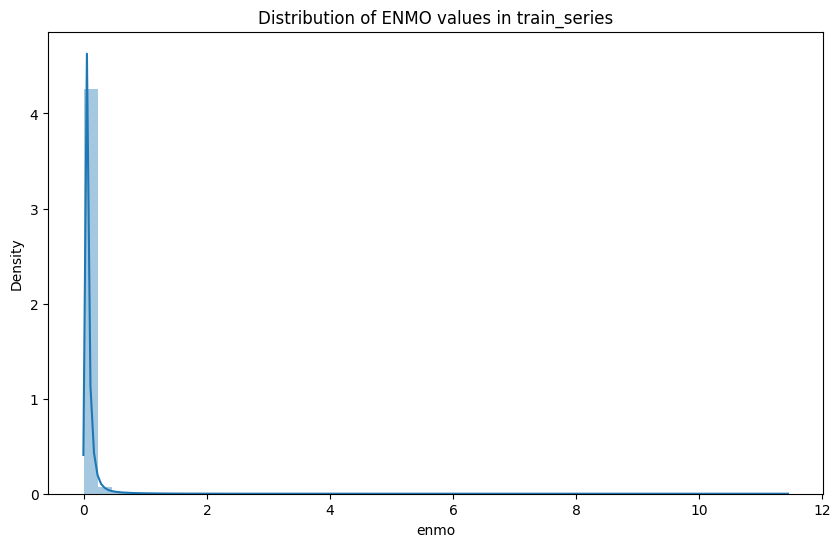

In [21]:
# plot the distribution of enmo-values
plt.figure(figsize=(10, 6))
ax = sns.distplot(full_train_data.enmo)
plt.title('Distribution of ENMO values in train_series')
plt.show()

In [22]:
# # fix huge enmo values (enmo > 99th percentile) at the level = 0.4

# full_train_data.loc[full_train_data.enmo > enmo_perc99, 'enmo'] = 0.4

In [23]:
# # plot the distribution of enmo-values
# plt.figure(figsize=(10, 6))
# ax = sns.distplot(full_train_data.enmo)
# plt.title('Distribution of ENMO values in train_series')
# plt.show()

In [24]:
mxa= full_train_data.anglez.max()
mna = full_train_data.anglez.min()
meana = full_train_data.anglez.mean()
sta = full_train_data.anglez.std()
perc75a = full_train_data.anglez.quantile(0.75)
perc90a = full_train_data.anglez.quantile(0.90)
perc99a = full_train_data.anglez.quantile(0.99)
print(f'anglez max is {mxa}')
print(f'anglez min is {mna}')
print(f'anglez mean is {meana}')
print(f'anglez standard deviation is {sta}')
print(f'anglez third quantile is {perc75a}')
print(f'anglez 90 percentile is {perc90a}')
print(f'anglez 99 percentile is {perc99a}')

anglez max is 90.0
anglez min is -90.0
anglez mean is nan
anglez standard deviation is 0.0
anglez third quantile is 11.21875
anglez 90 percentile is 39.53125
anglez 99 percentile is 78.875


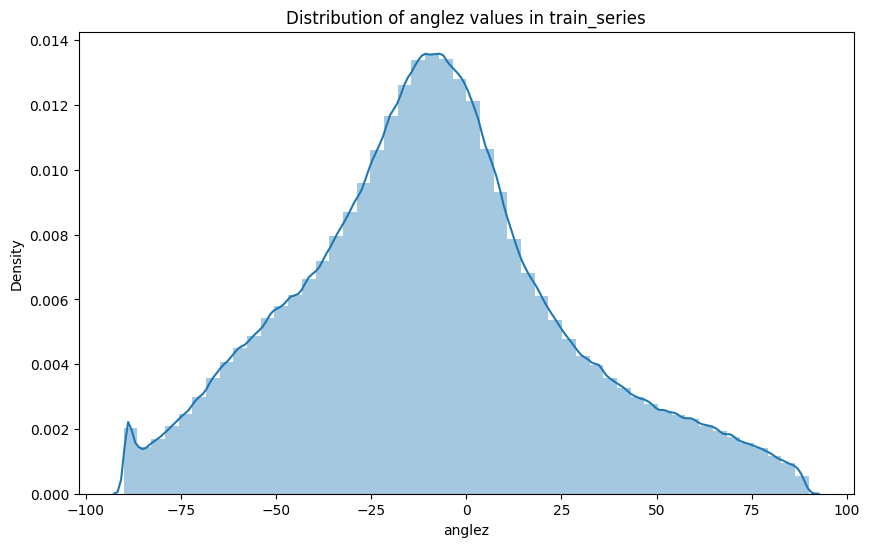

In [25]:
# plot the distribution of anglez-values
plt.figure(figsize=(10, 6))
ax = sns.distplot(full_train_data.anglez)
plt.title('Distribution of anglez values in train_series')
plt.show()

In [26]:
gc.collect()

6262

In [27]:
train_events = pd.read_csv("/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")
train_events.head()

series_id  night   event     step                 timestamp
0  038441c925bb      1   onset   4992.0  2018-08-14T22:26:00-0400
1  038441c925bb      1  wakeup  10932.0  2018-08-15T06:41:00-0400
2  038441c925bb      2   onset  20244.0  2018-08-15T19:37:00-0400
3  038441c925bb      2  wakeup  27492.0  2018-08-16T05:41:00-0400
4  038441c925bb      3   onset  39996.0  2018-08-16T23:03:00-0400

In [28]:
train_events.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [29]:
events = drop_nulls(train_events)

In [30]:
gc.collect()

0

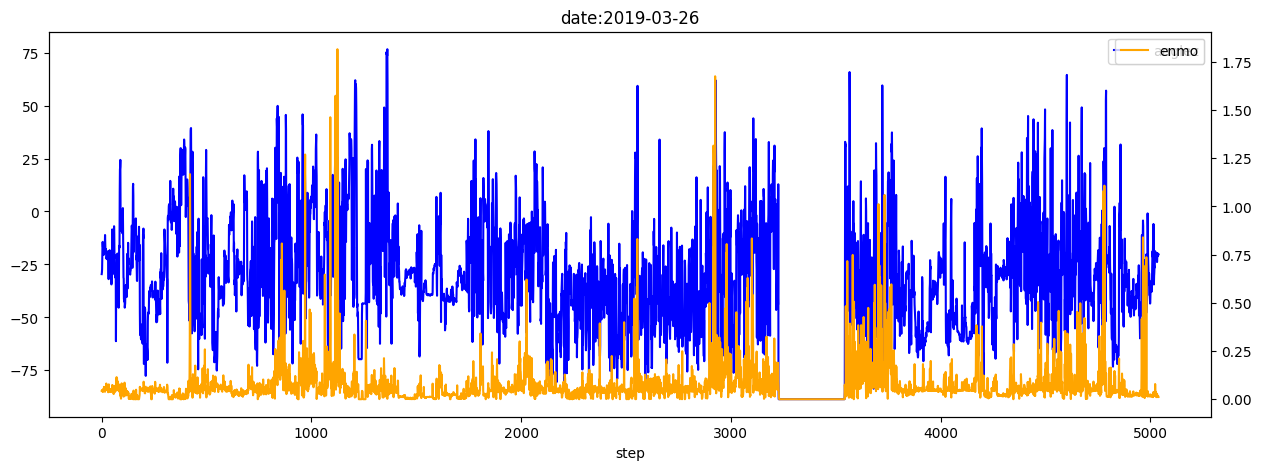

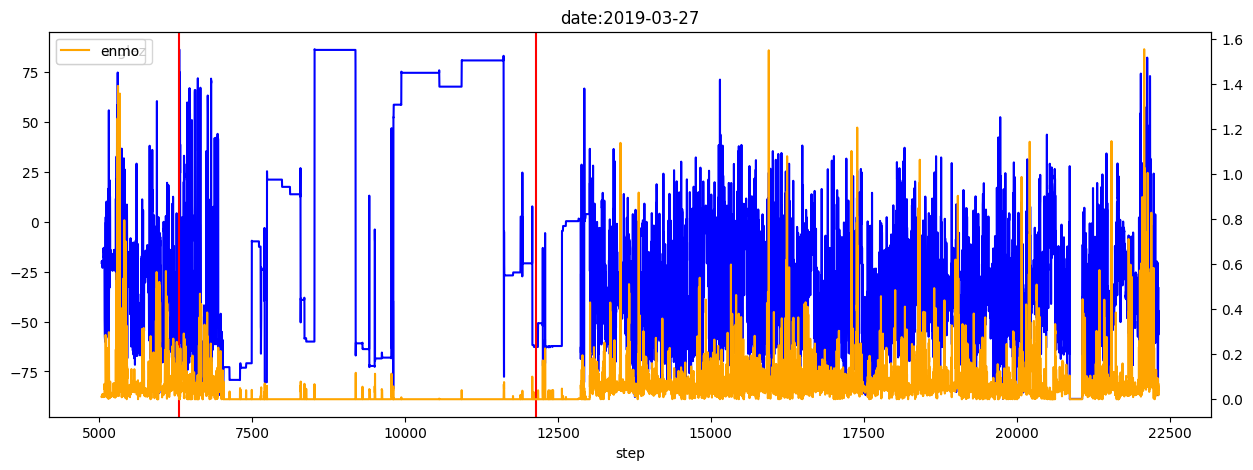

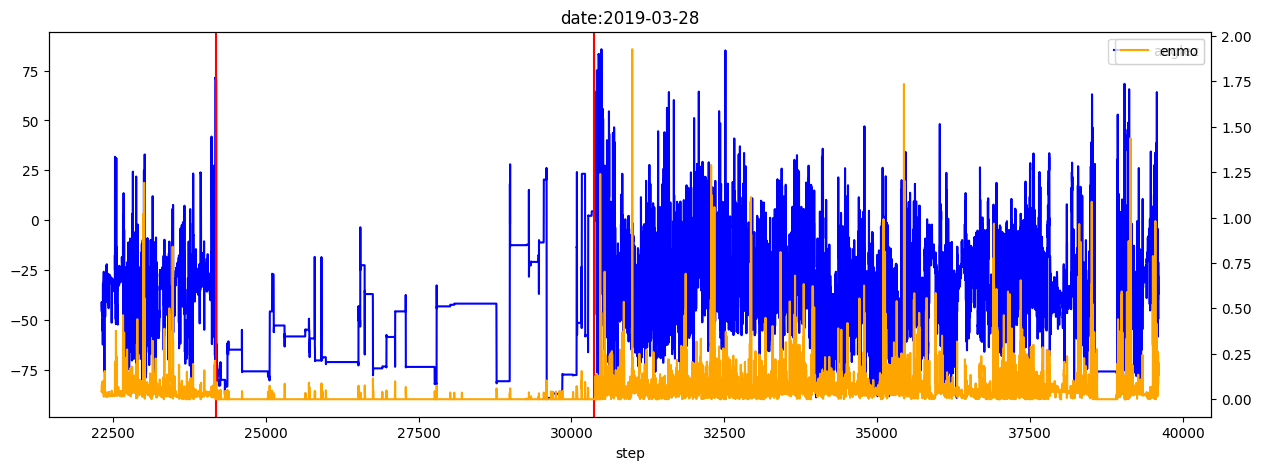

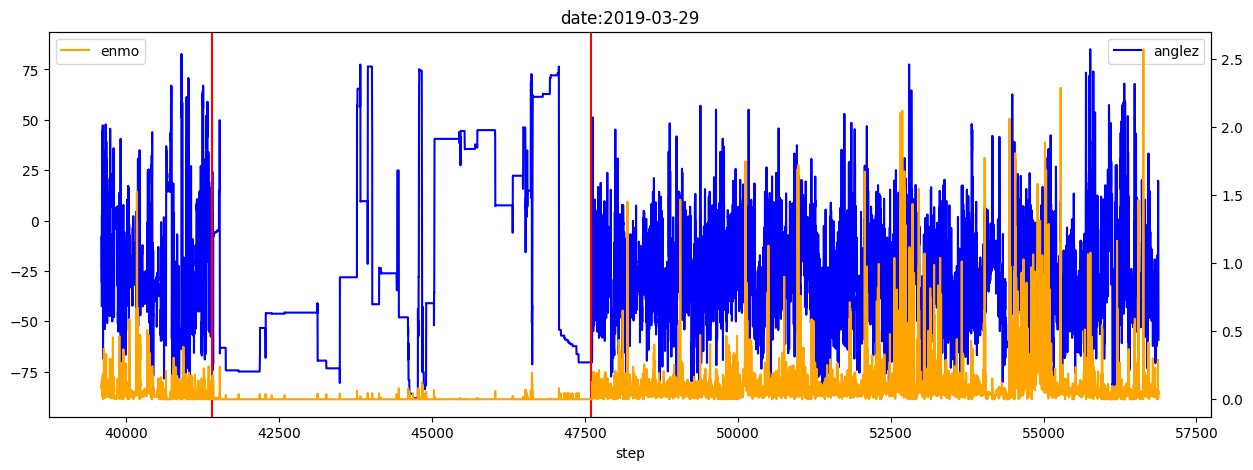

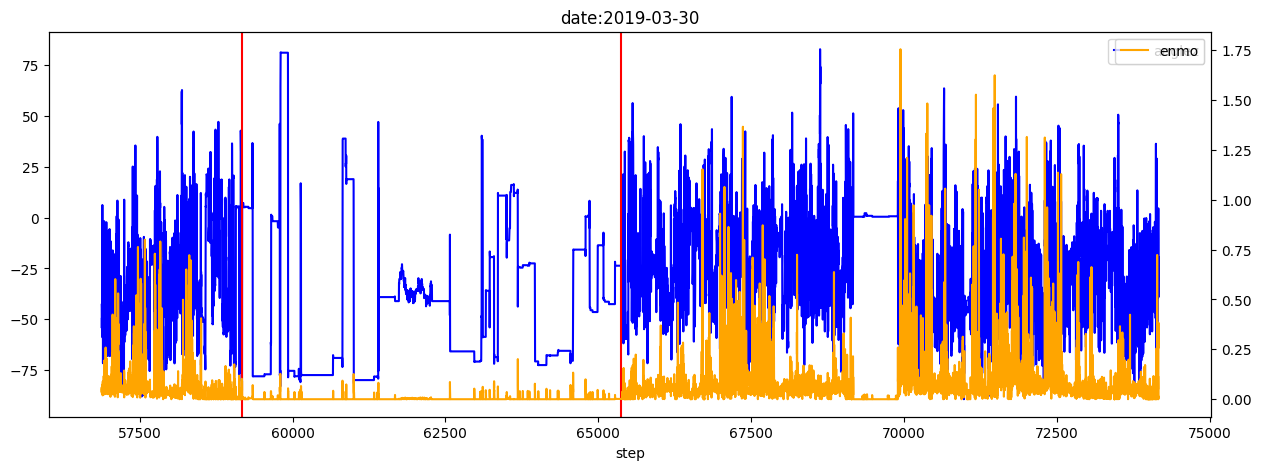

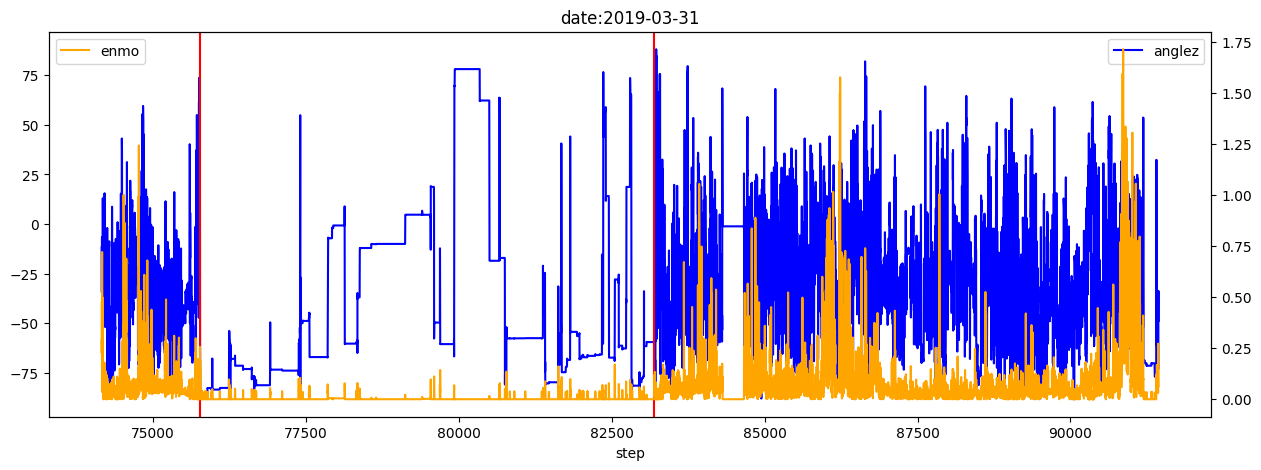

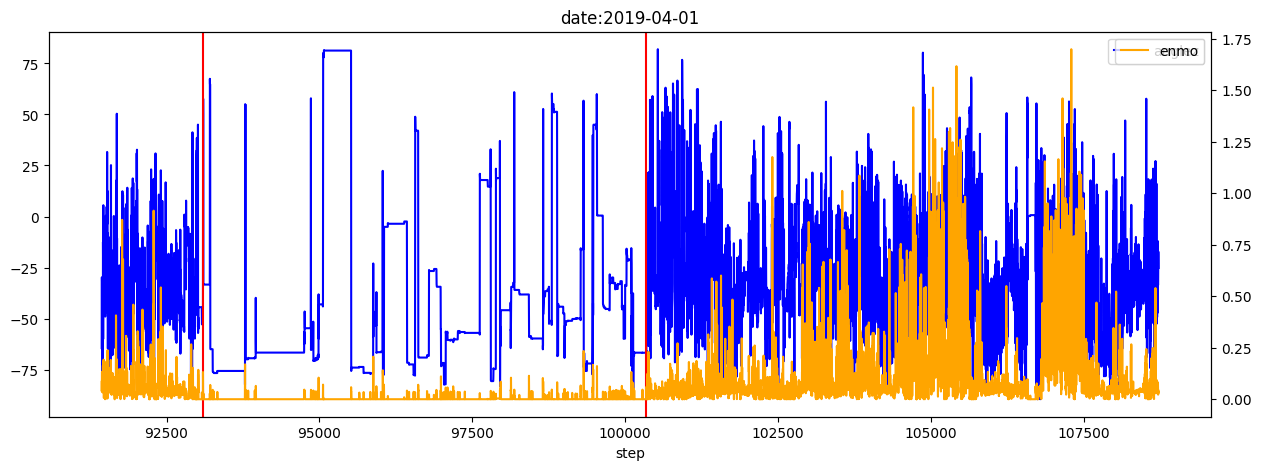

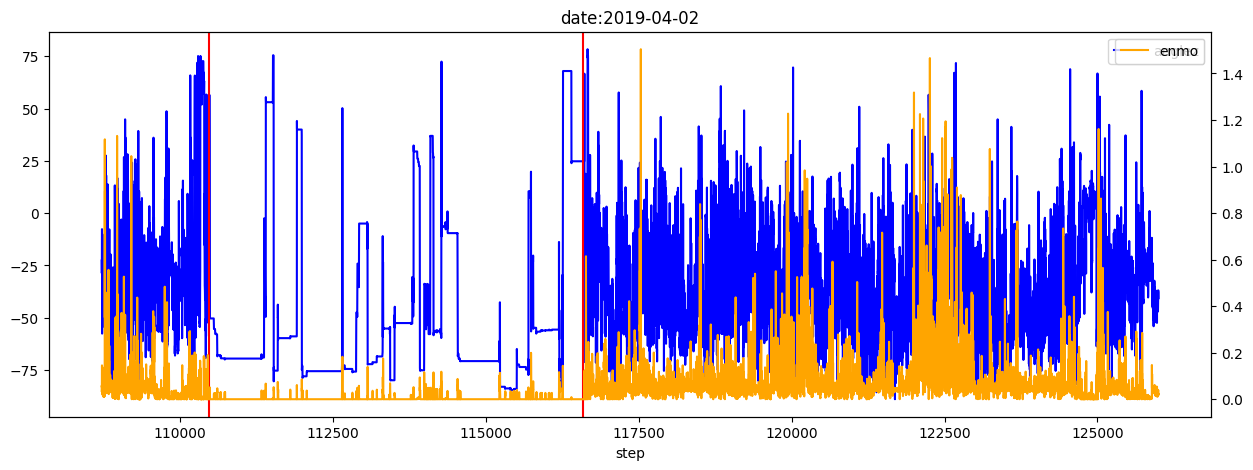

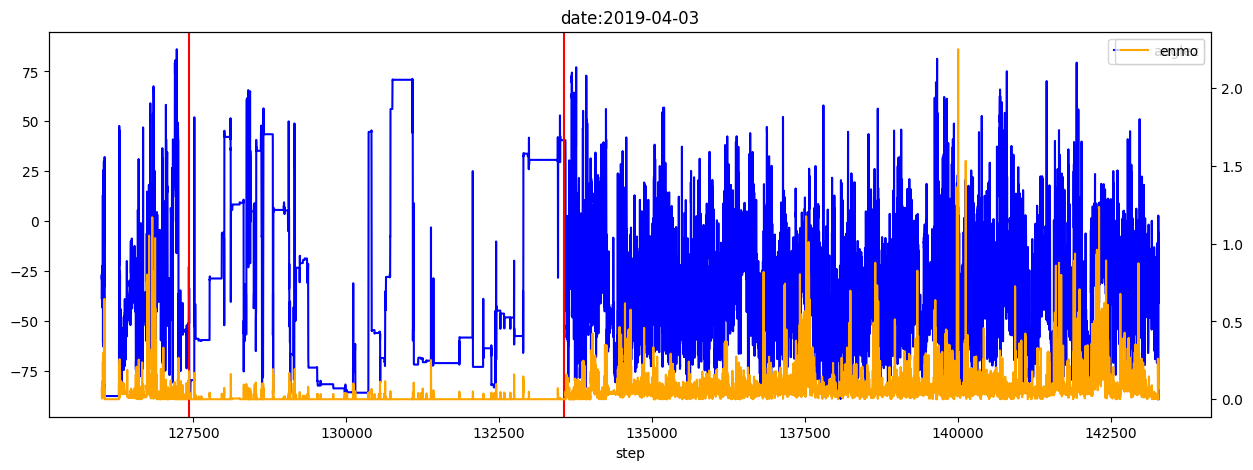

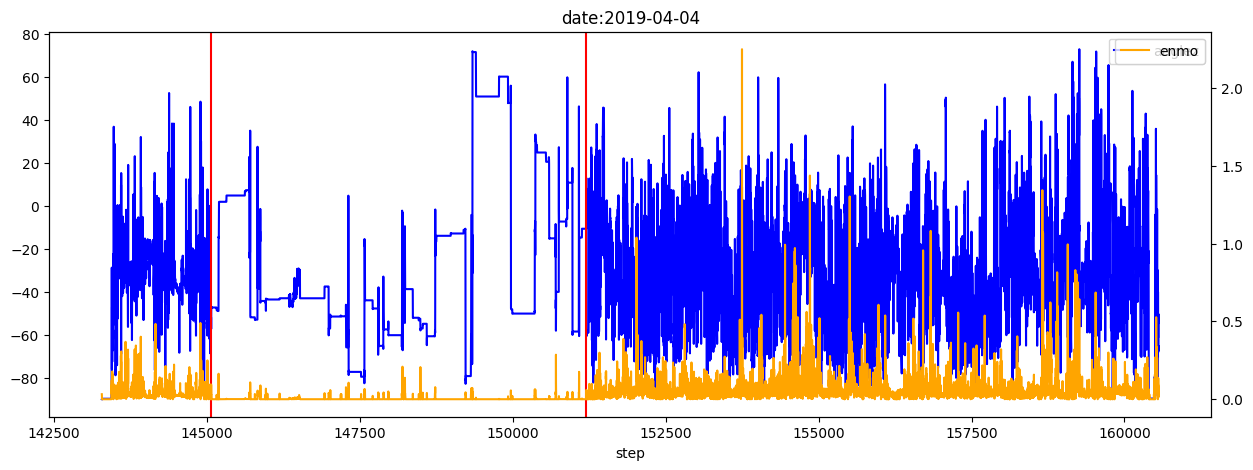

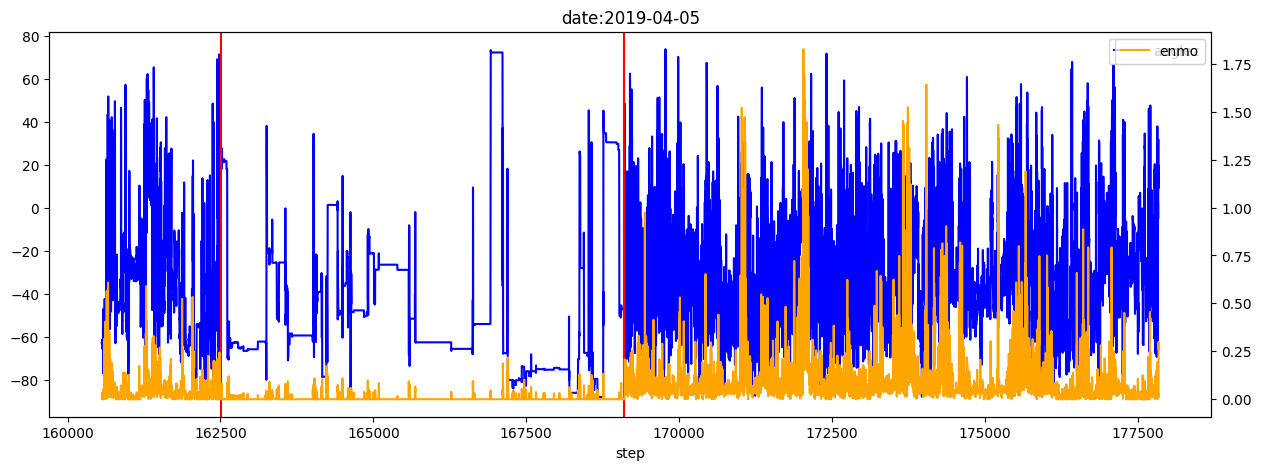

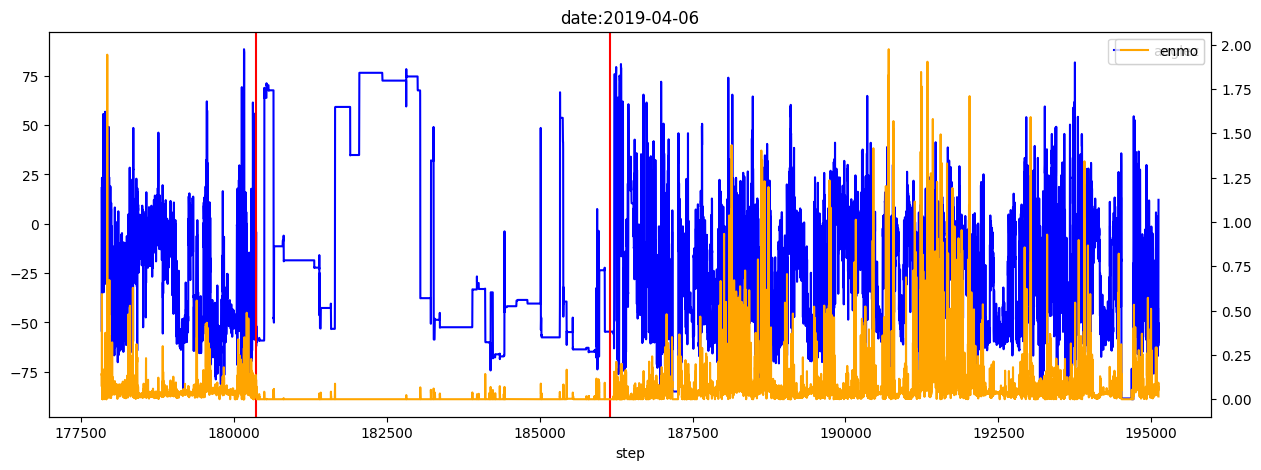

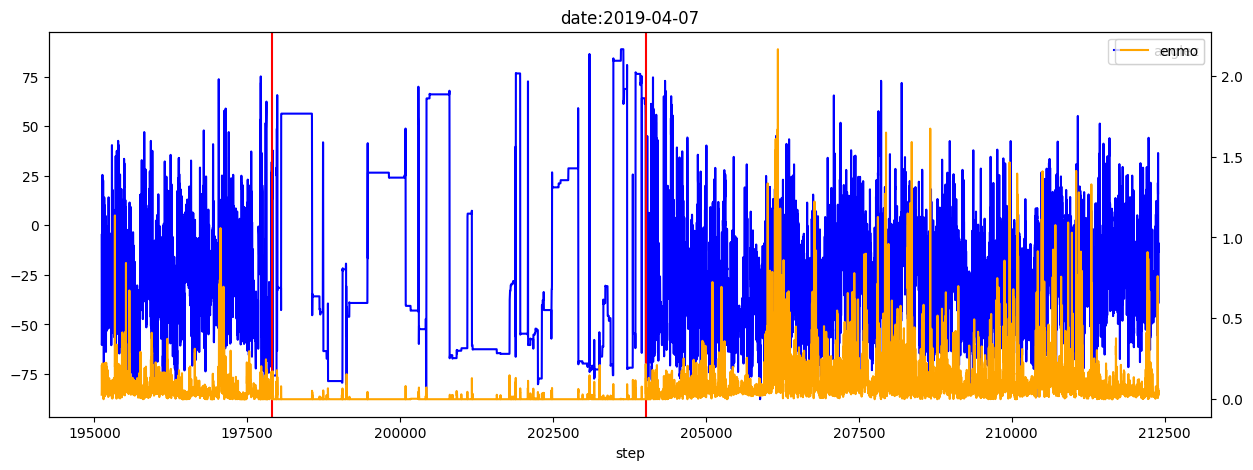

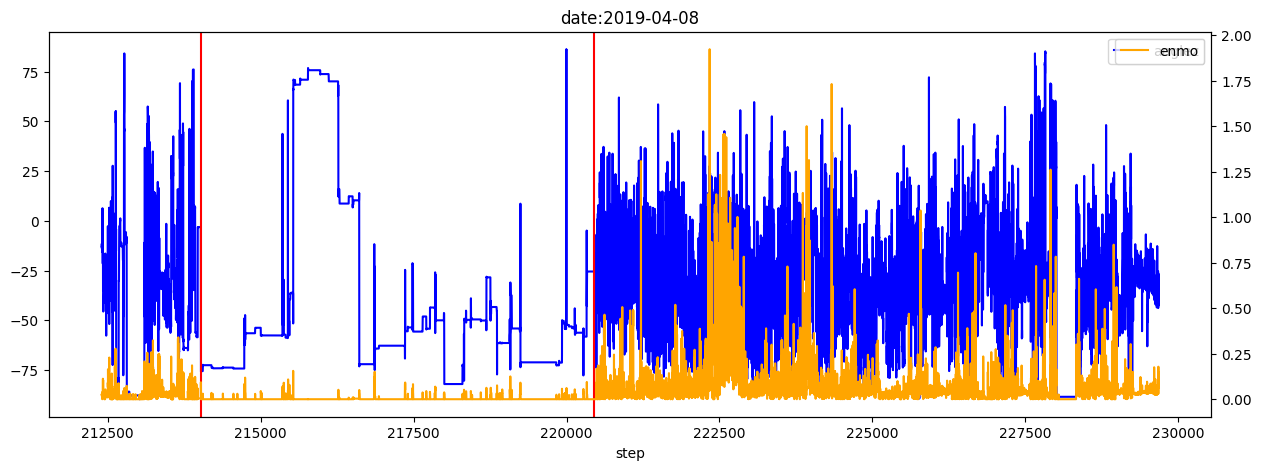

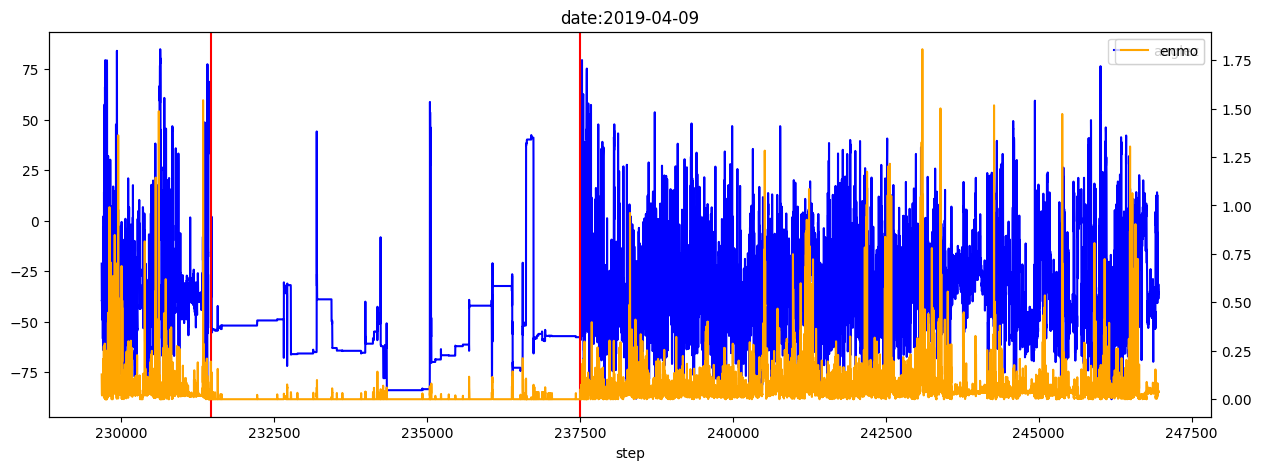

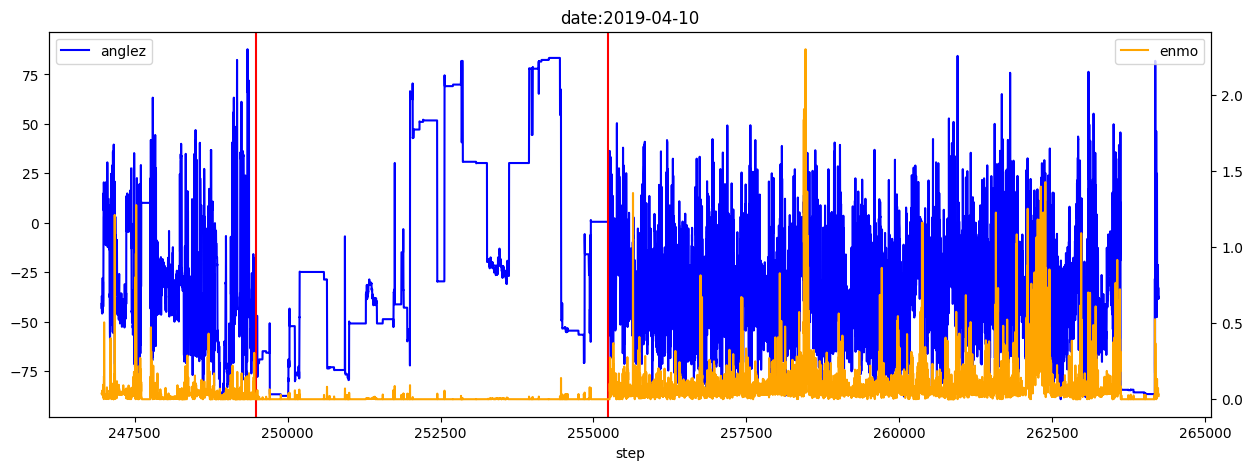

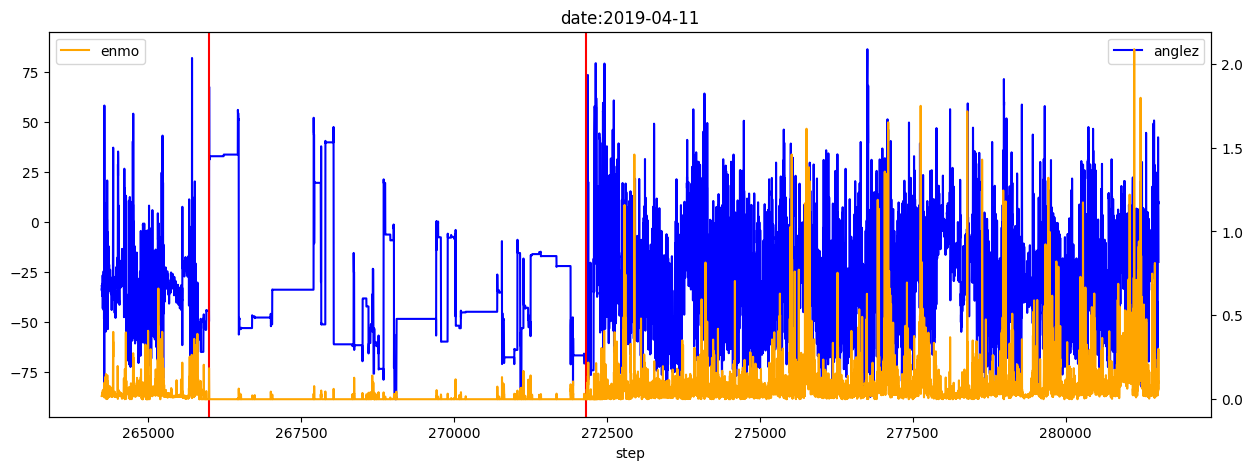

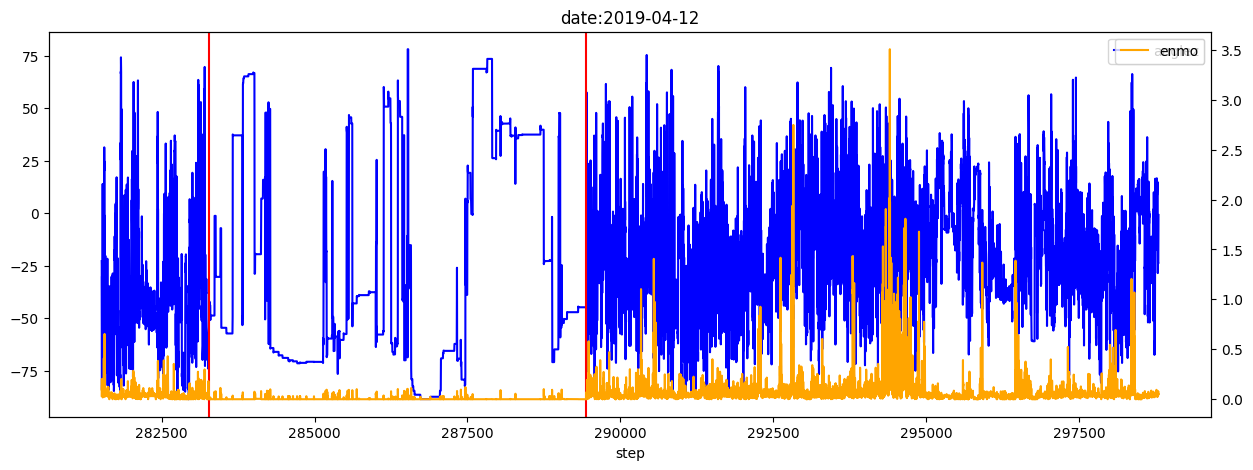

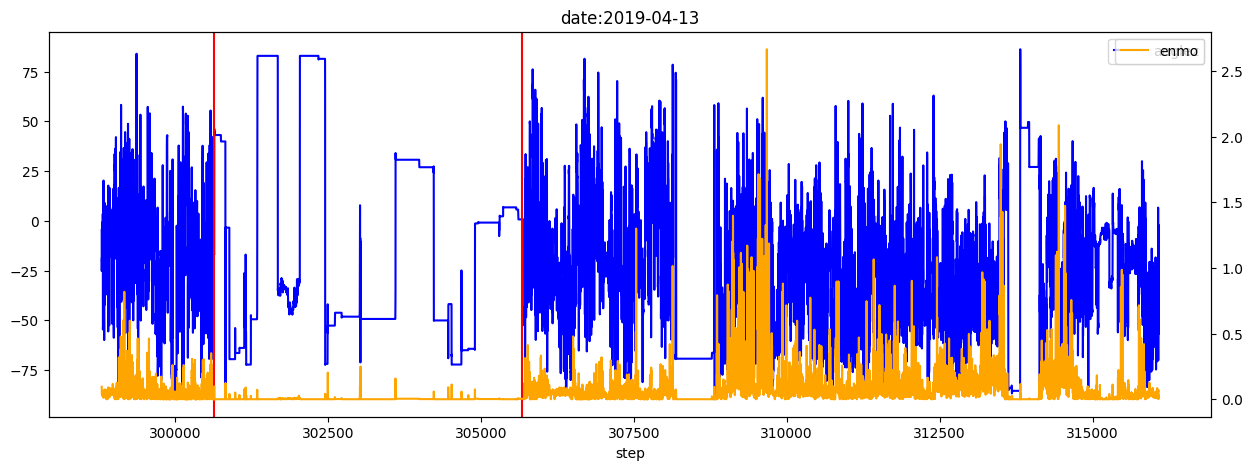

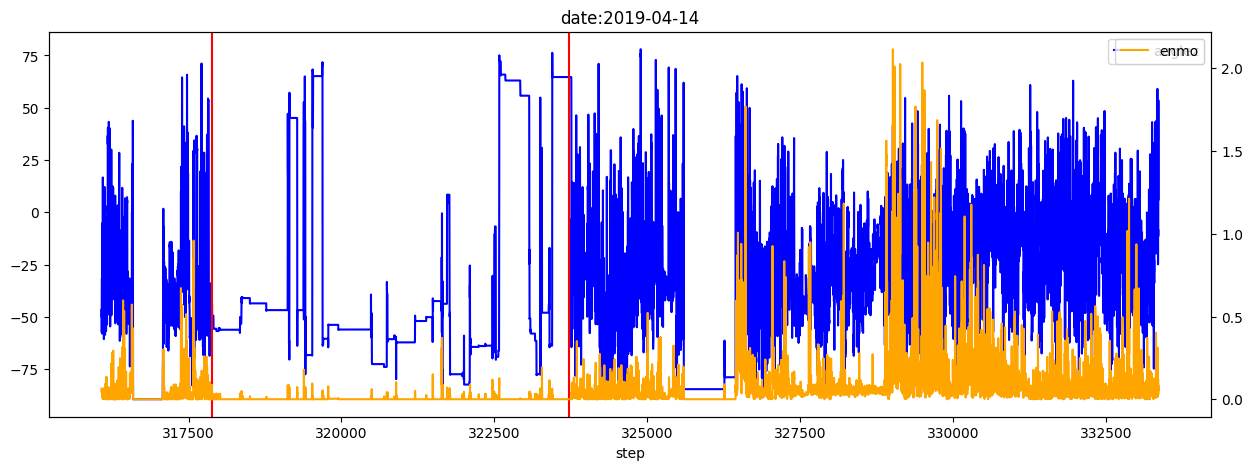

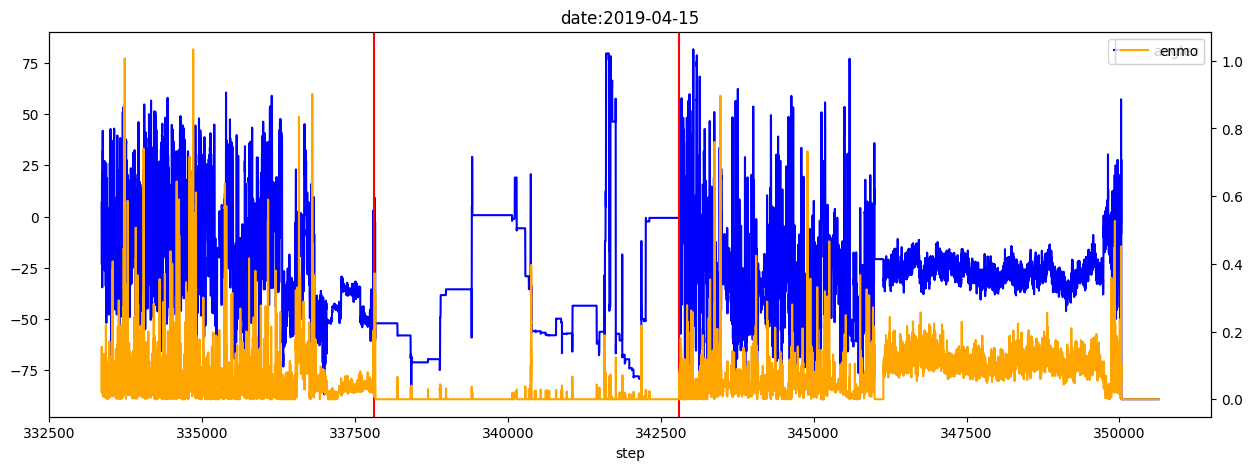

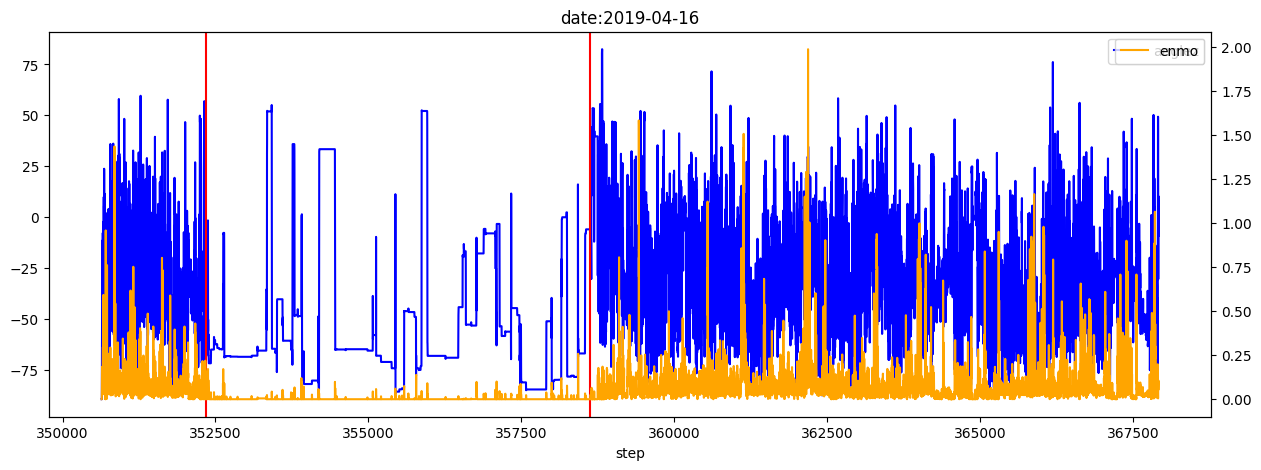

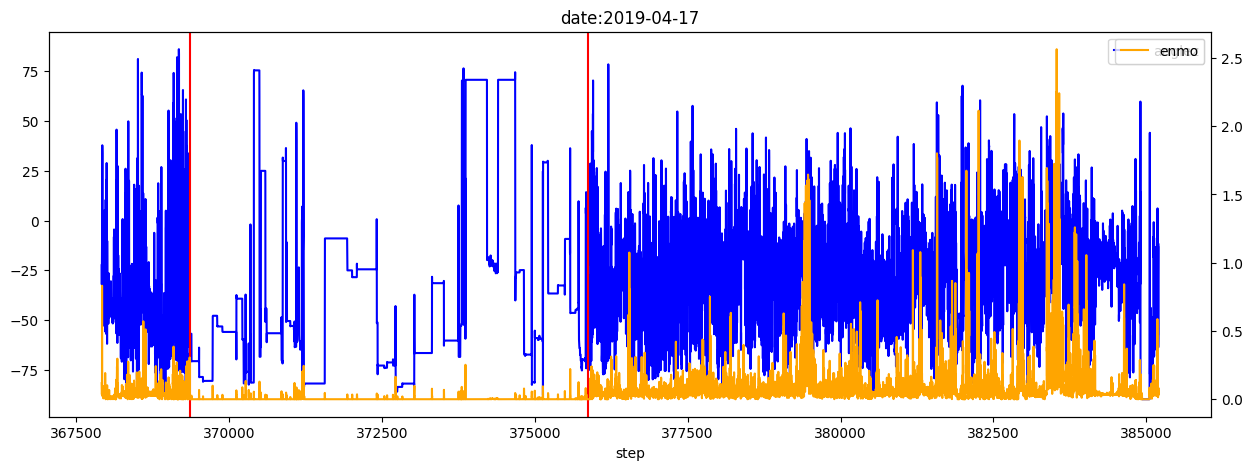

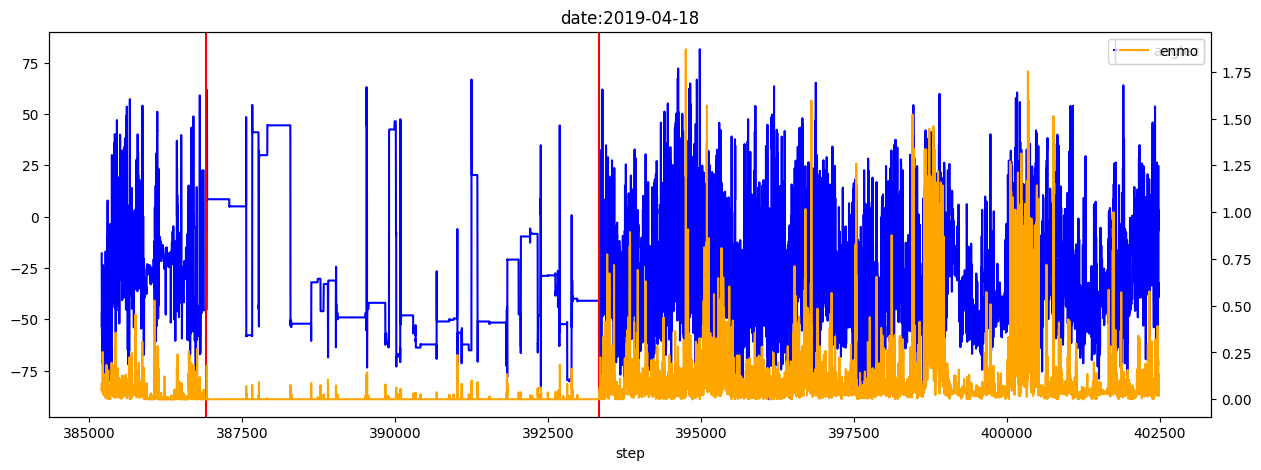

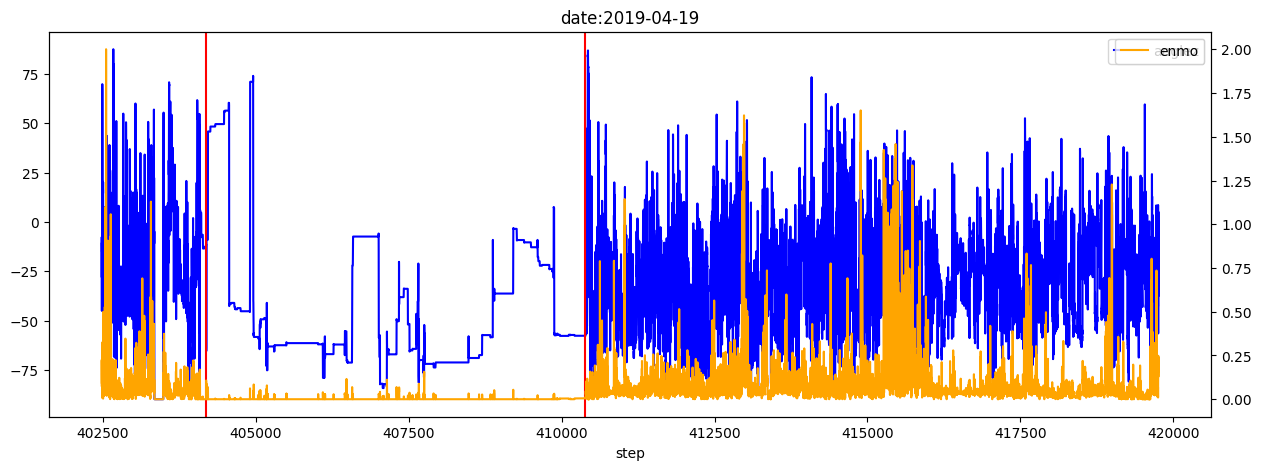

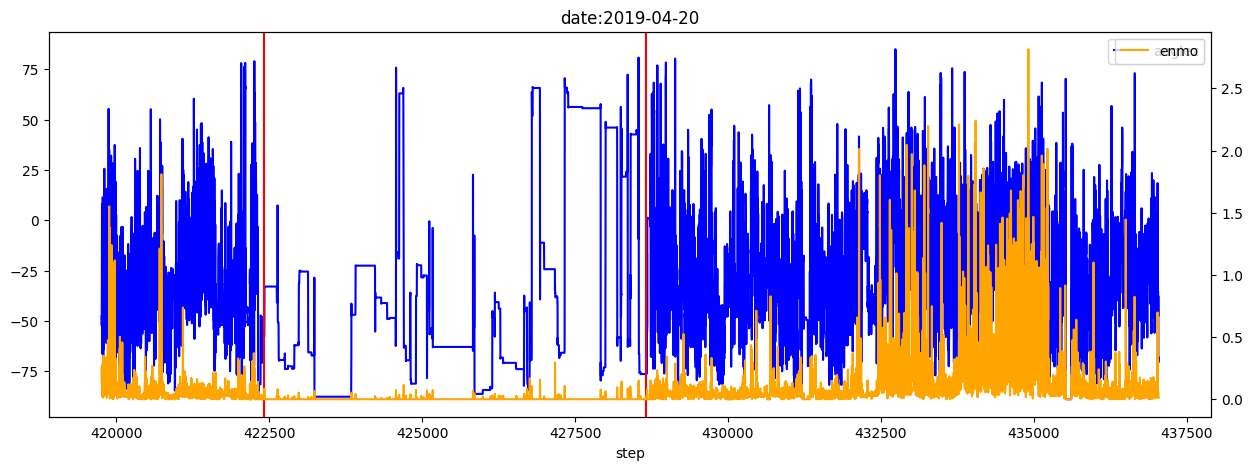

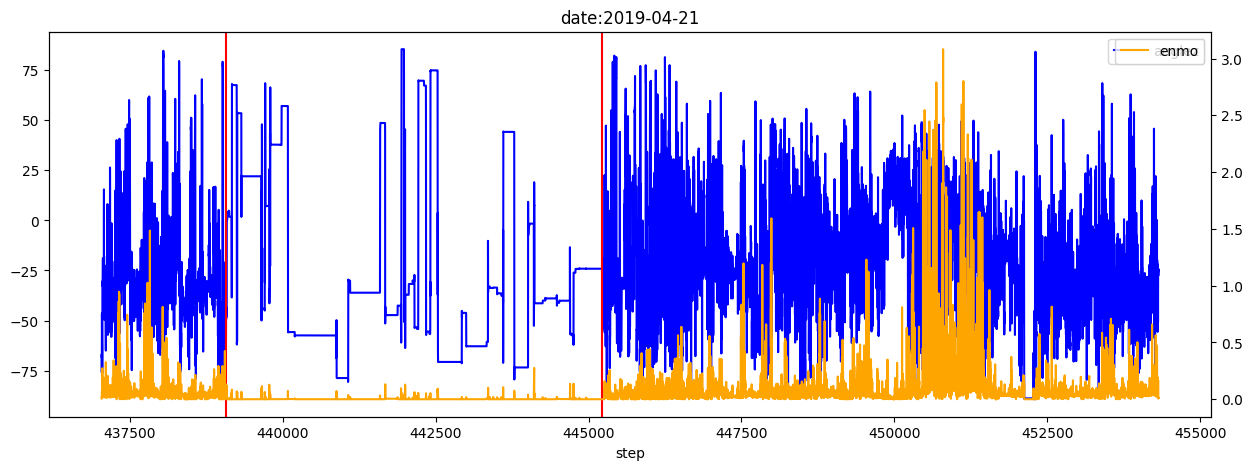

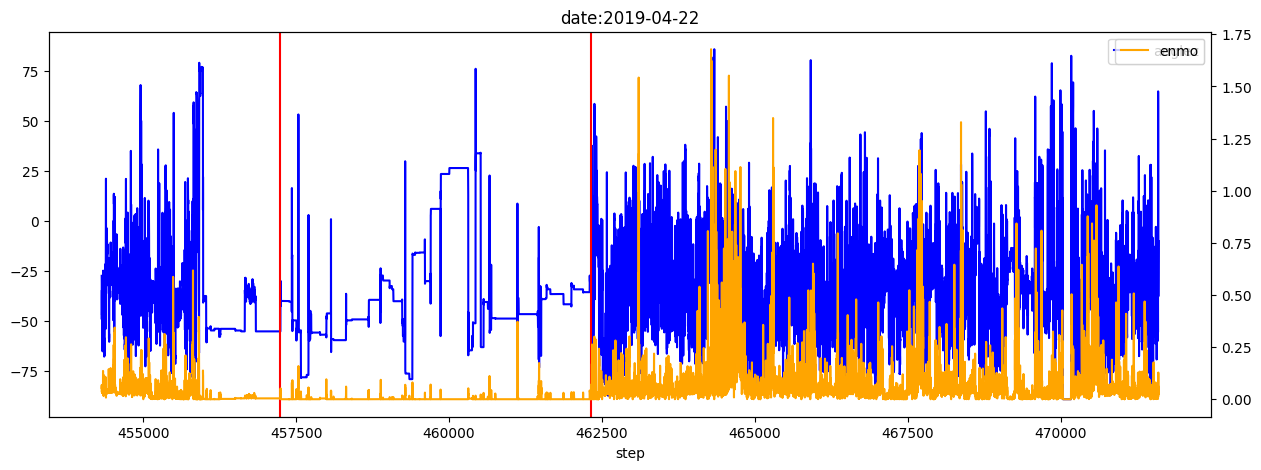

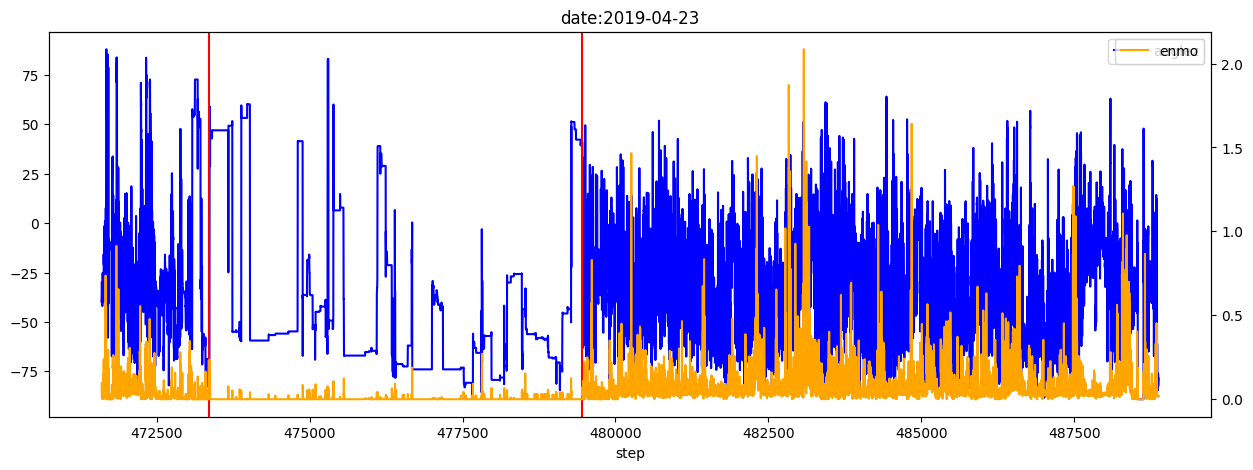

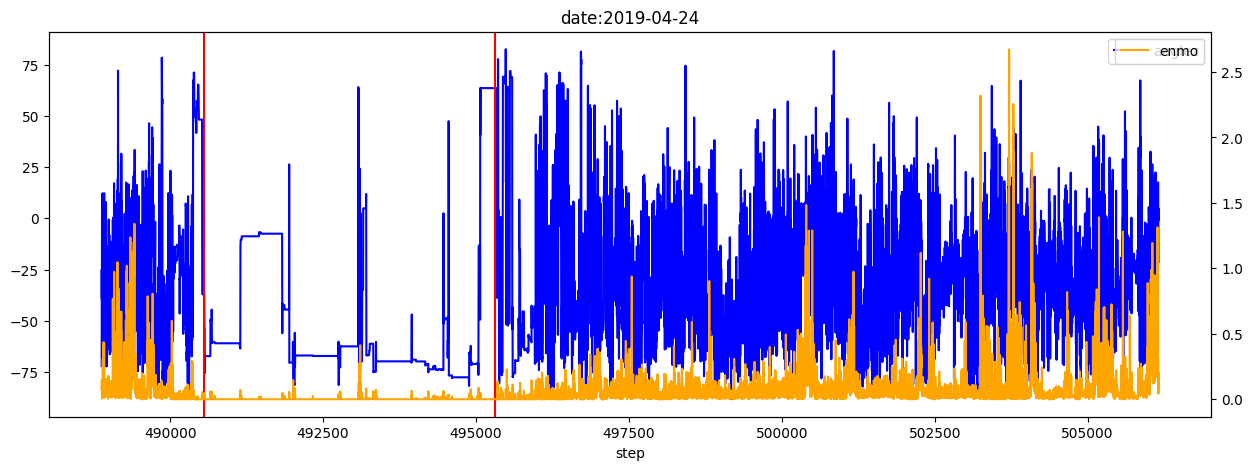

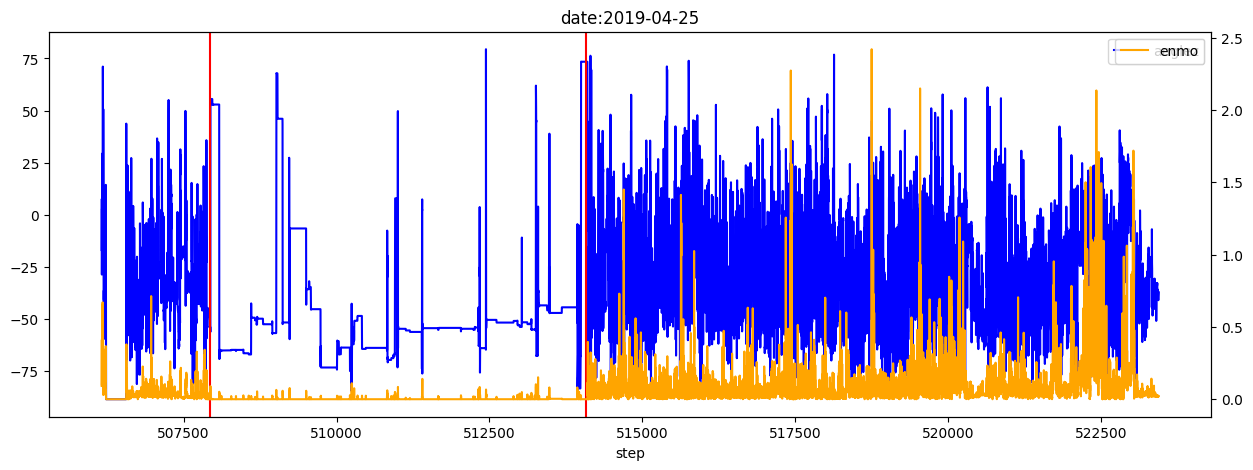

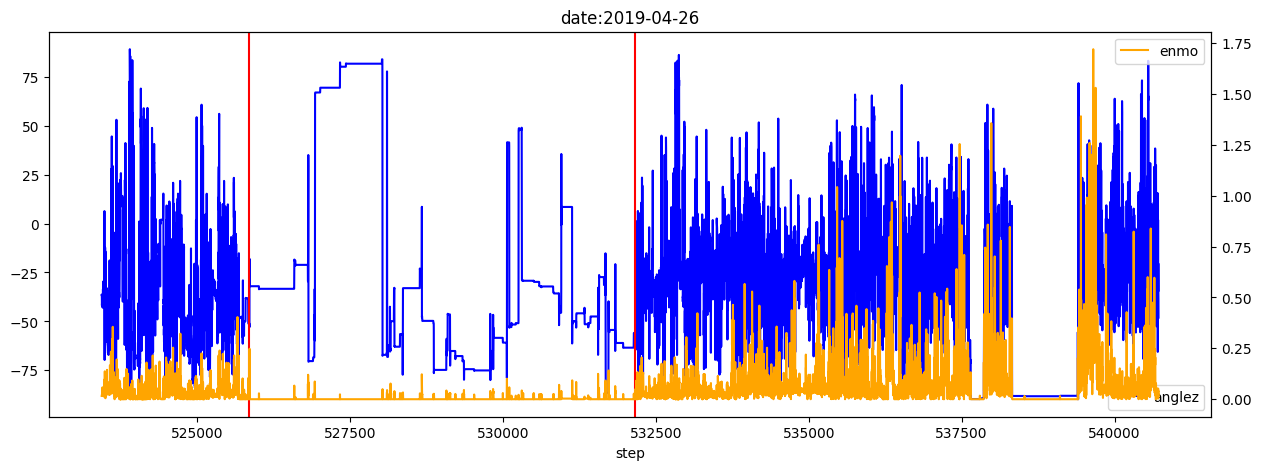

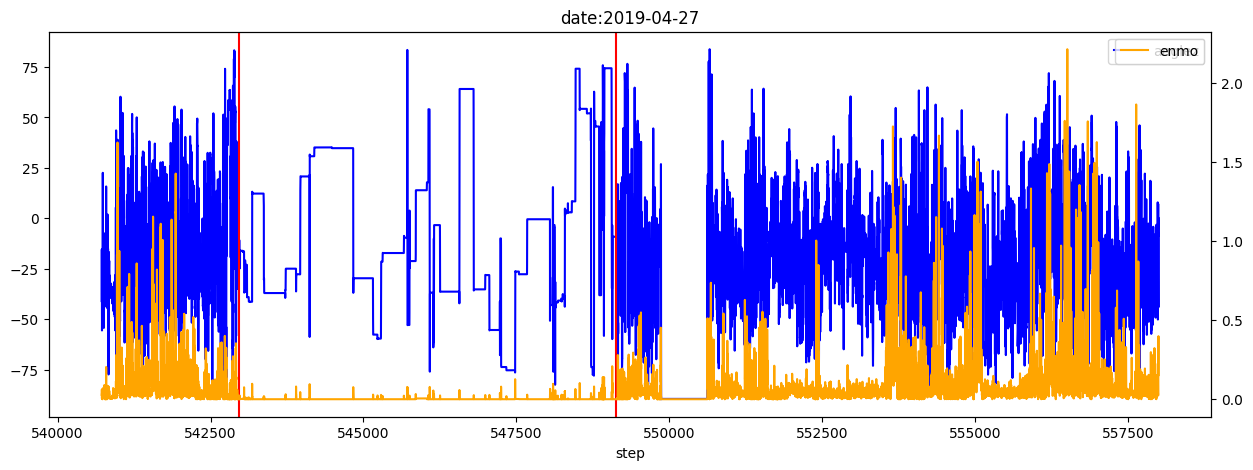

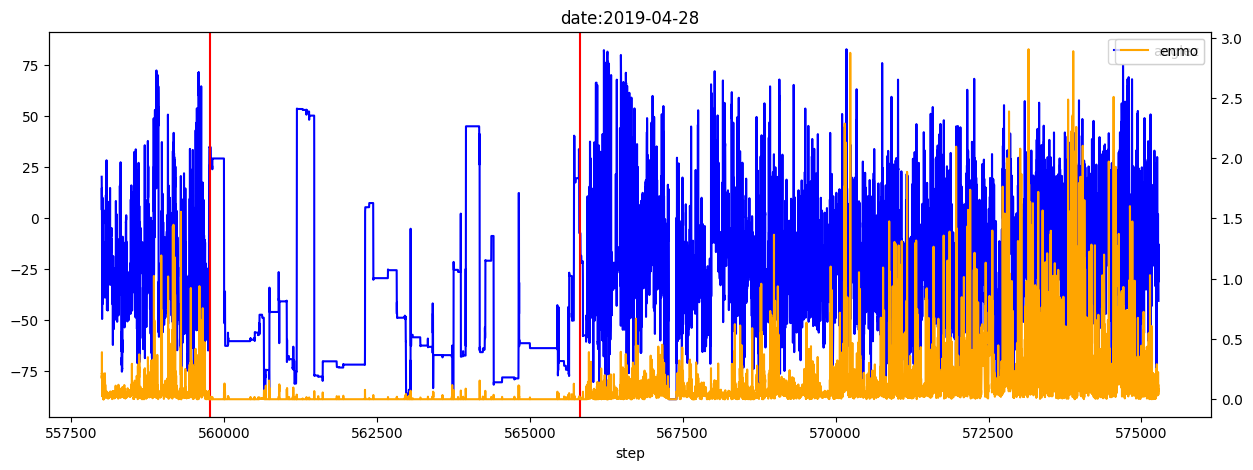

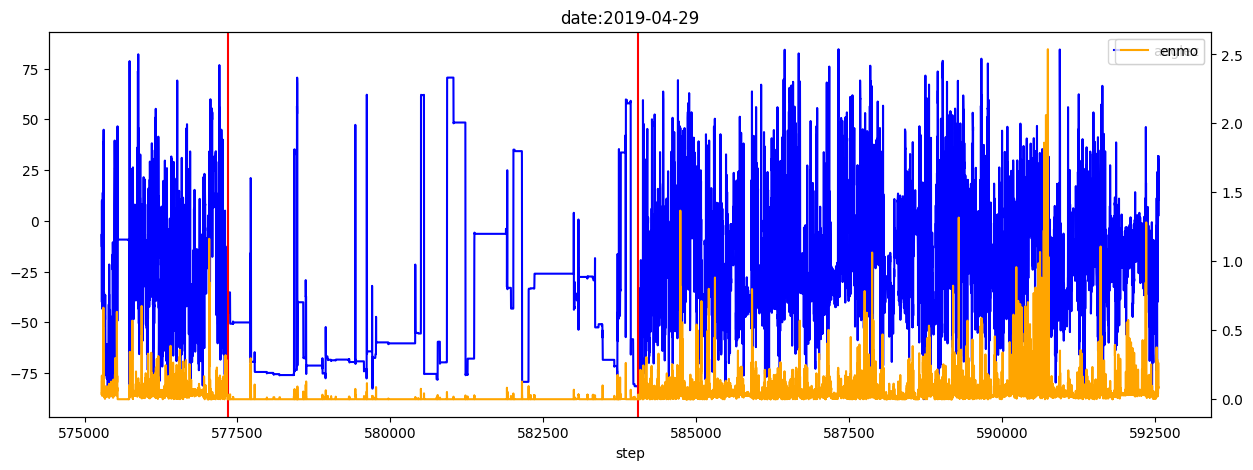

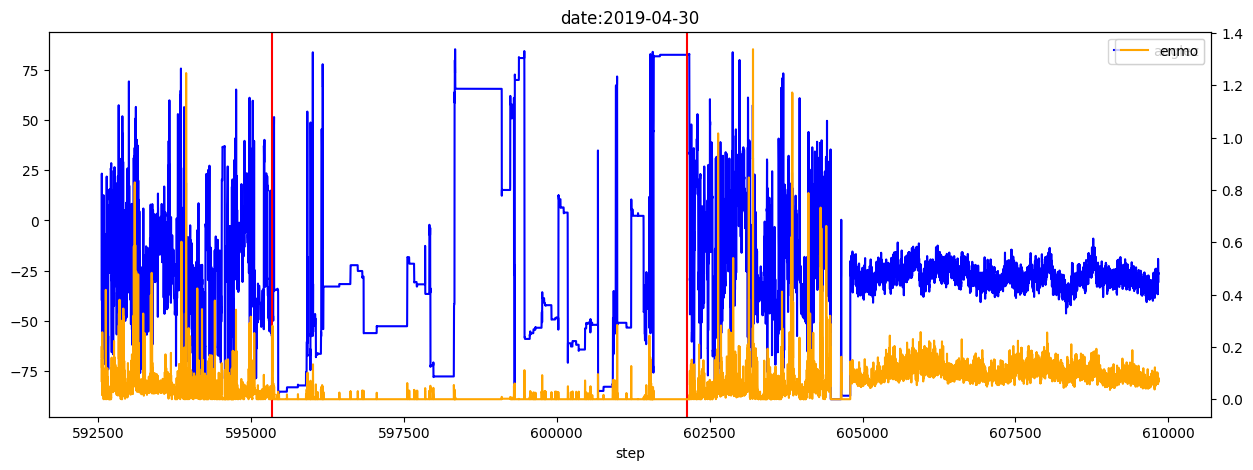

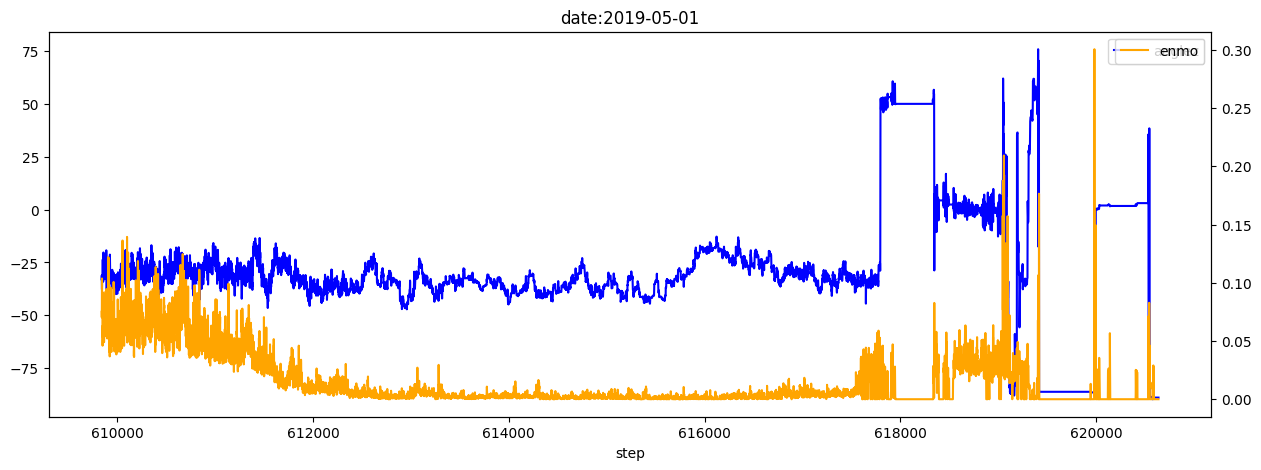

In [31]:
def plot_example(id):
    df_example= train_data.loc[train_data["series_id"]==id].reset_index(drop = True).copy()
    df_example["timestamp"] = pd.to_datetime(df_example["timestamp"],utc = True)
    df_example["date"] = df_example["timestamp"].dt.date
    for date, data in df_example.groupby("date"):
        step_min = data["step"].min()
        step_max = data["step"].max()
        series_id = data["series_id"].values[0]
        fig, ax = plt.subplots(figsize=(15,5))
        data.set_index("step")[["anglez"]].plot(ax= ax,color = "blue", title = f"date:{date}")
        ax2 = ax.twinx()
        data.set_index("step")[["enmo"]].plot(ax= ax2, color = "orange")
        my_events = events.query(
        "series_id == @series_id and step >= @step_min and step <= @step_max"
        )
        for i, e in my_events.iterrows():
            ax.axvline(e["step"],color = "red")
        plt.show()

plot_example("fcca183903b7")

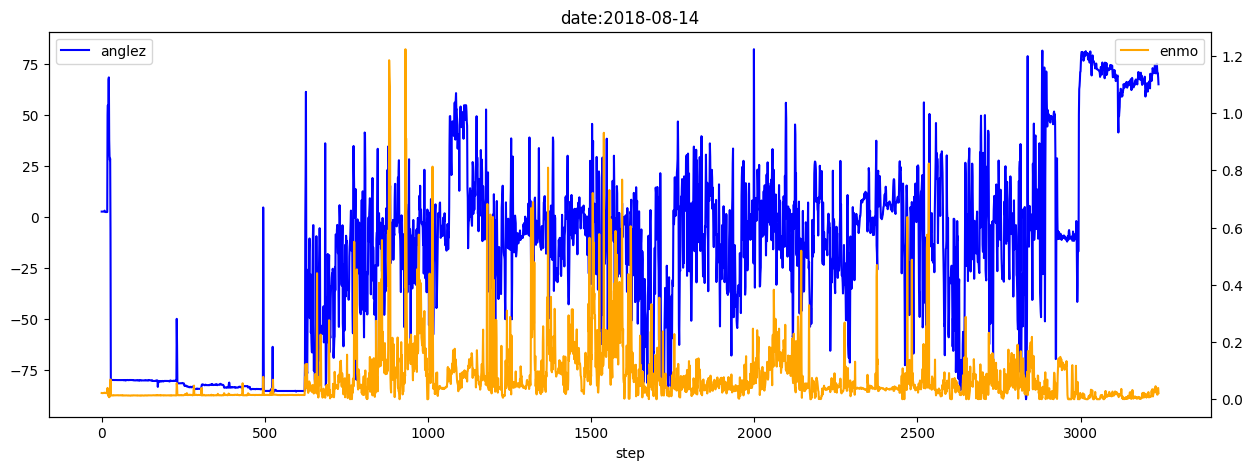

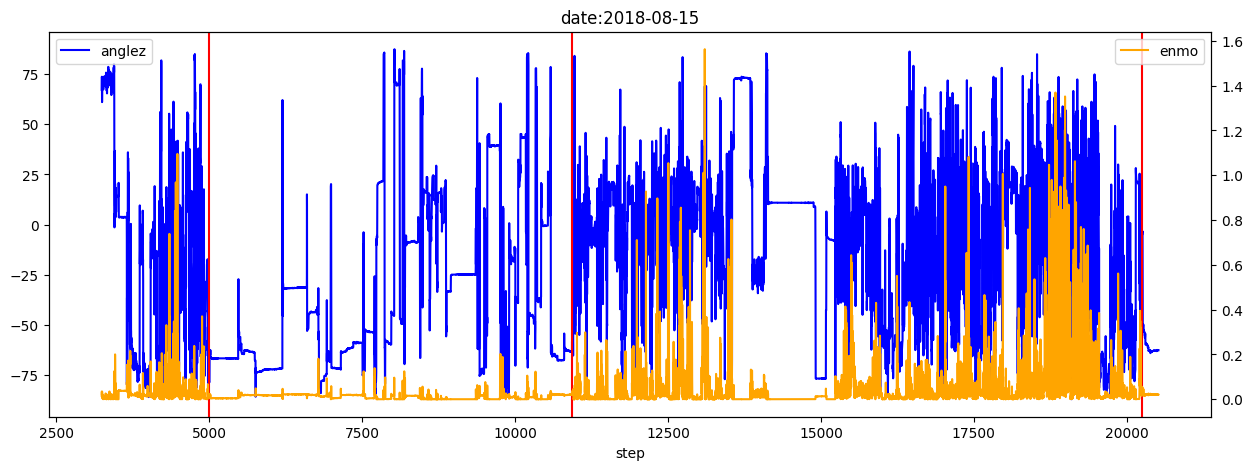

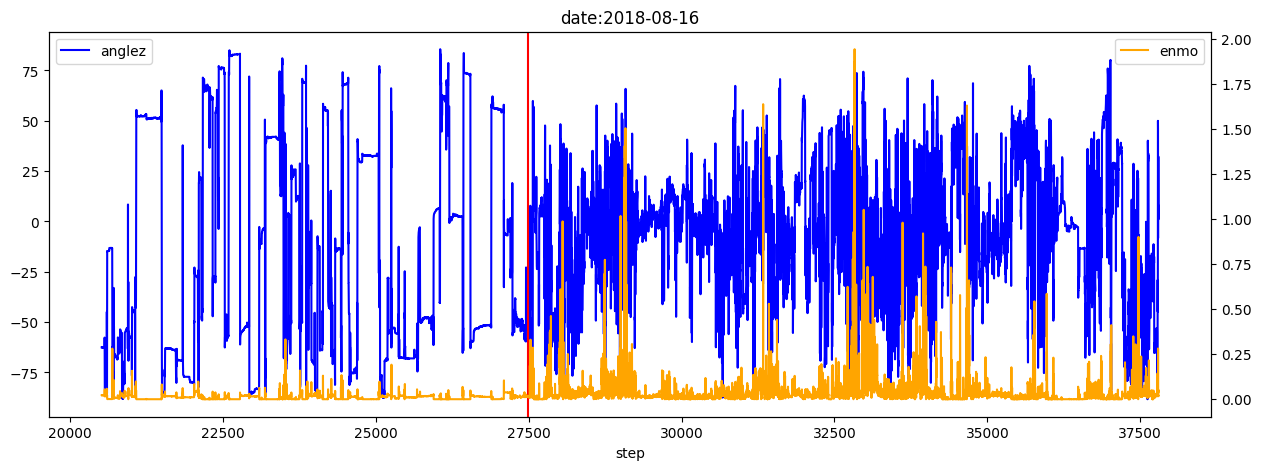

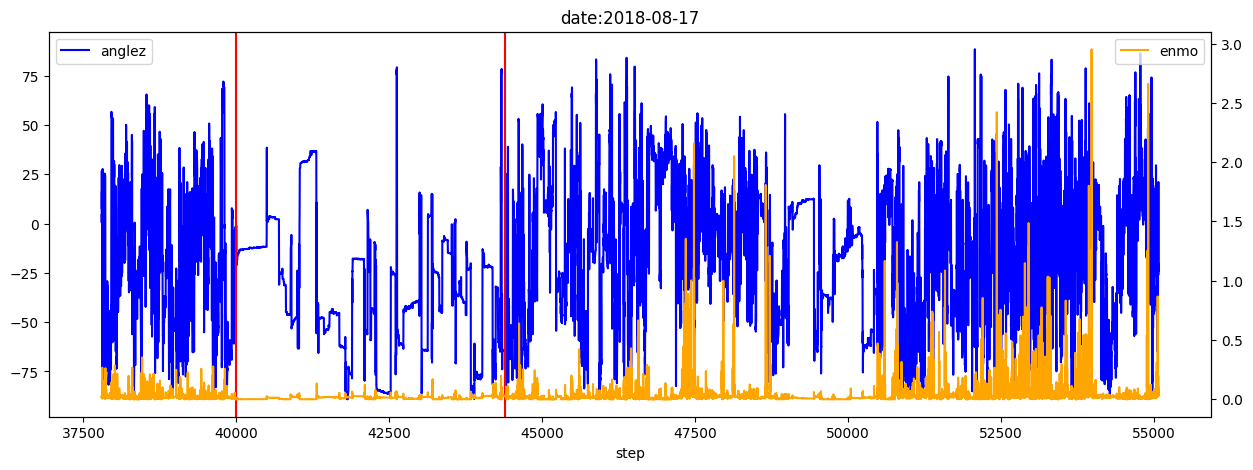

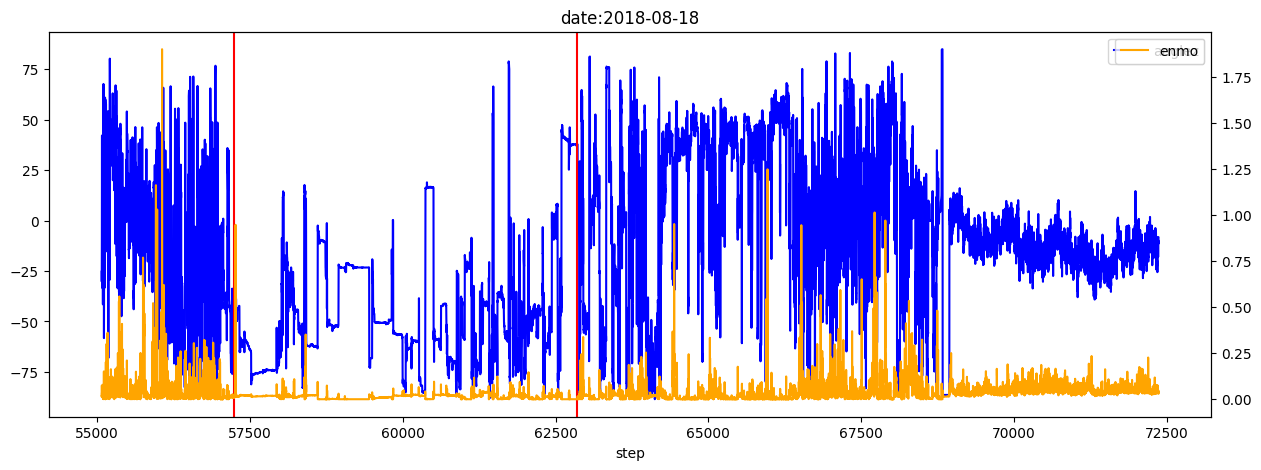

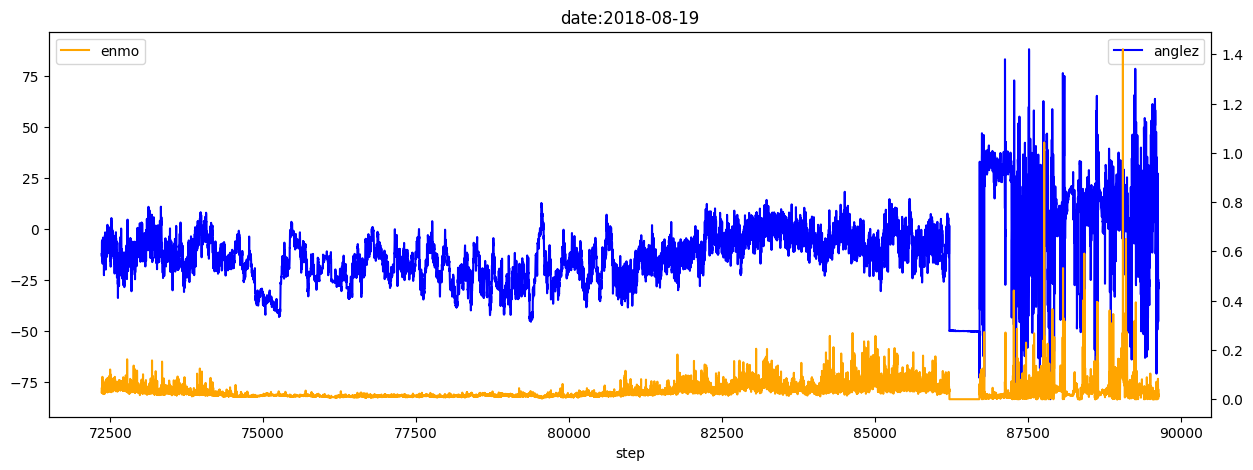

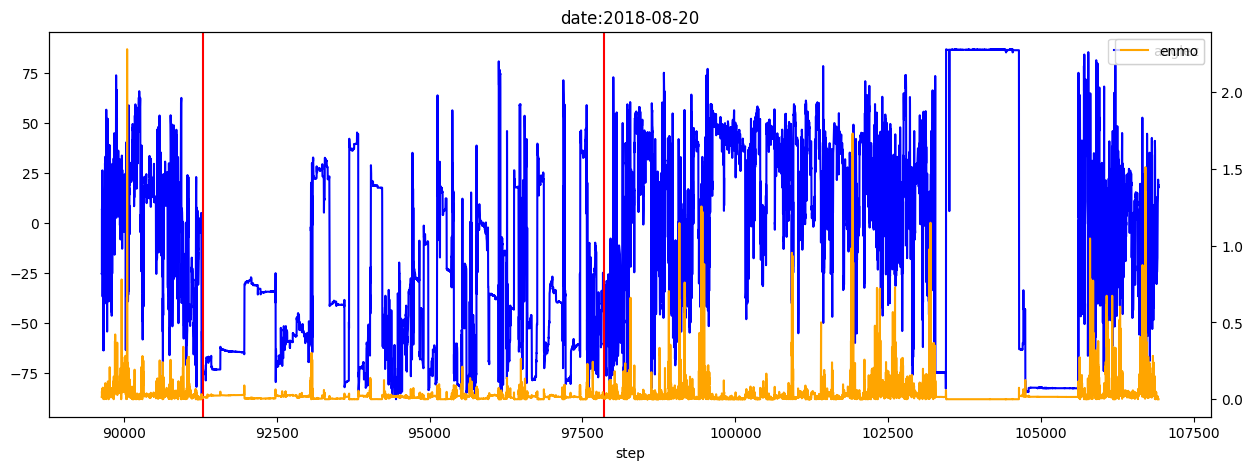

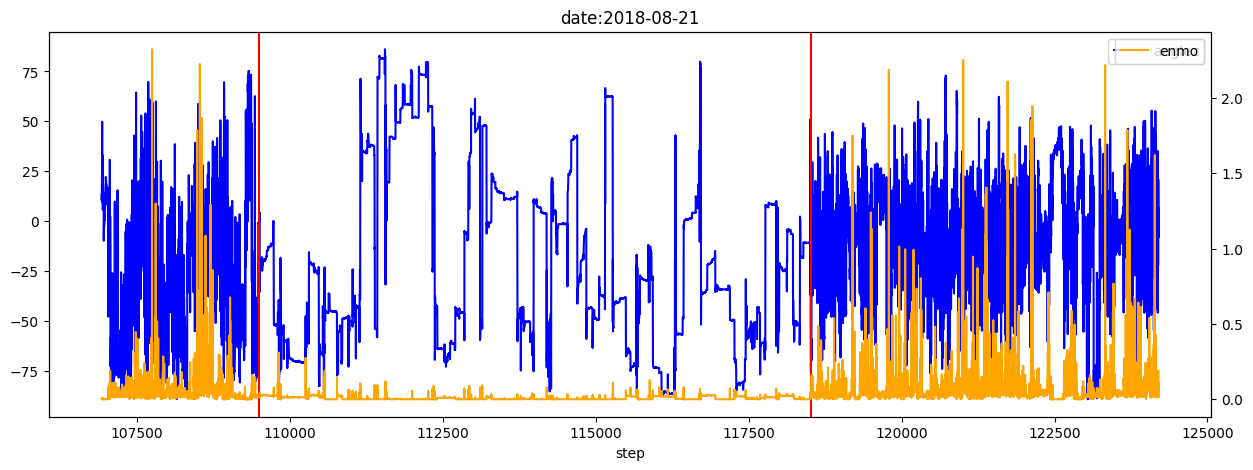

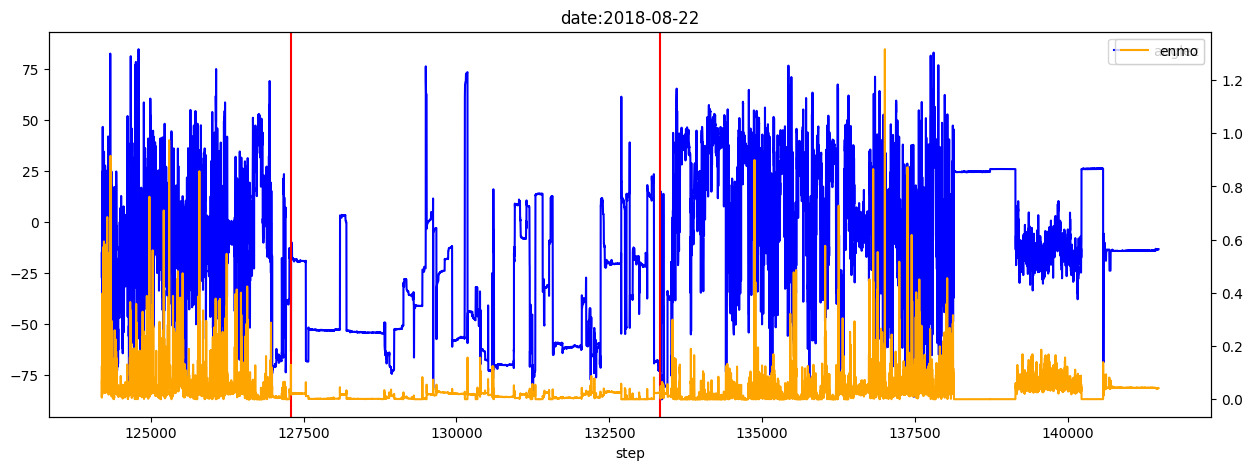

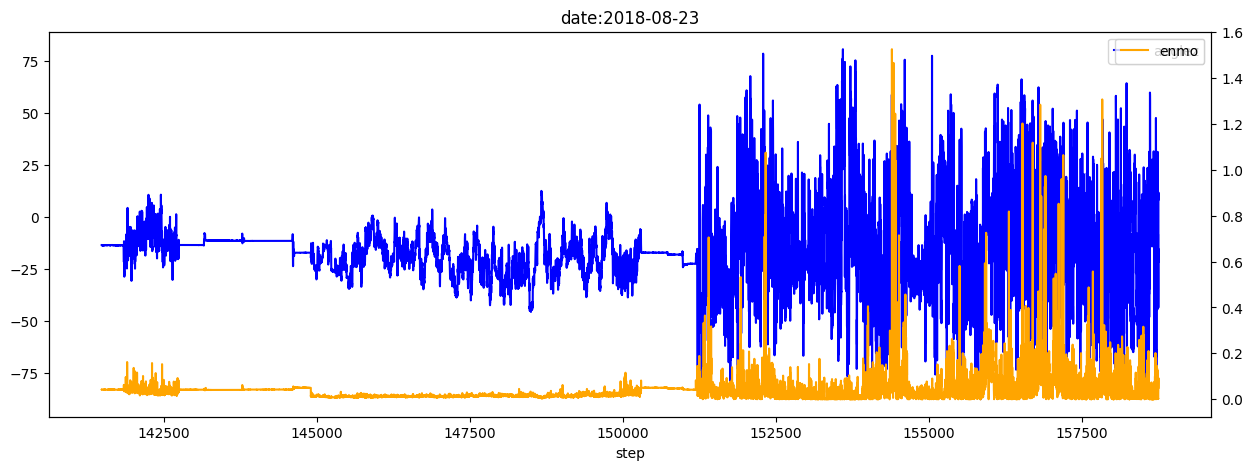

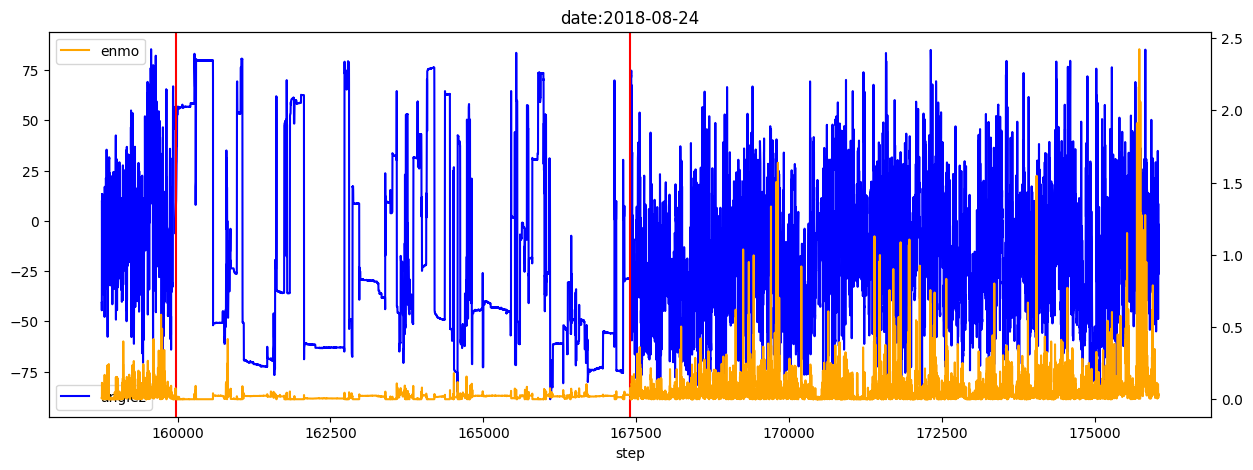

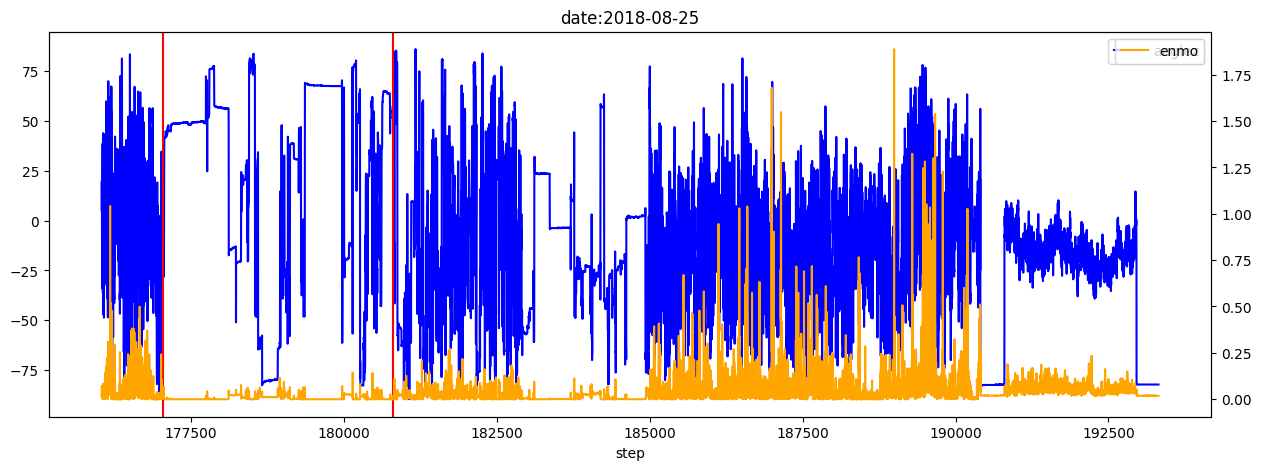

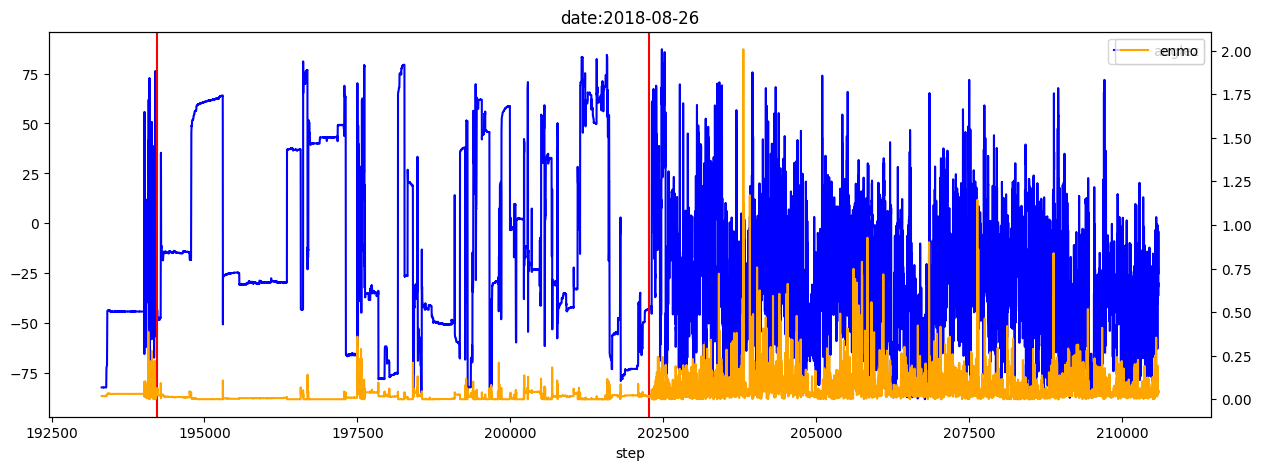

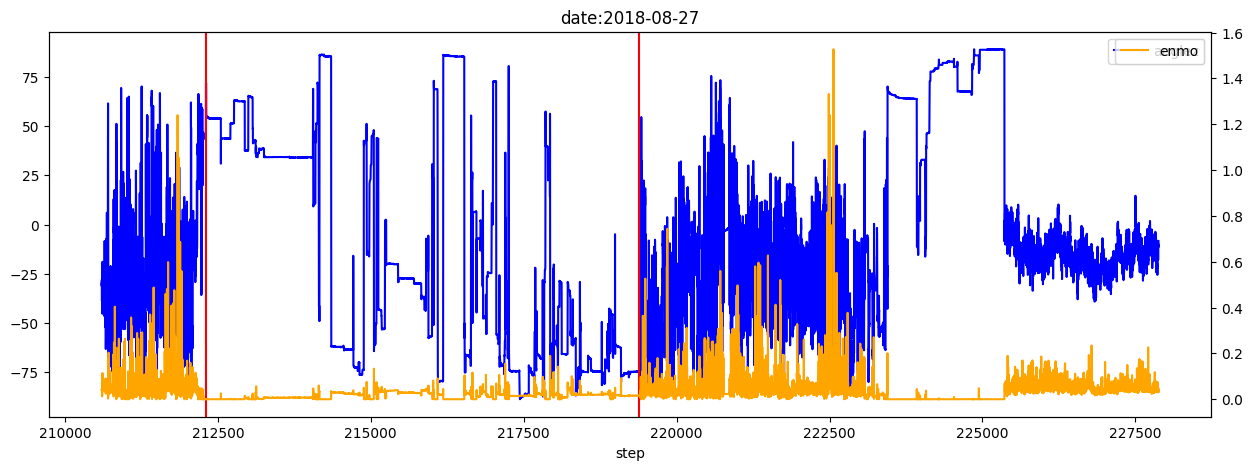

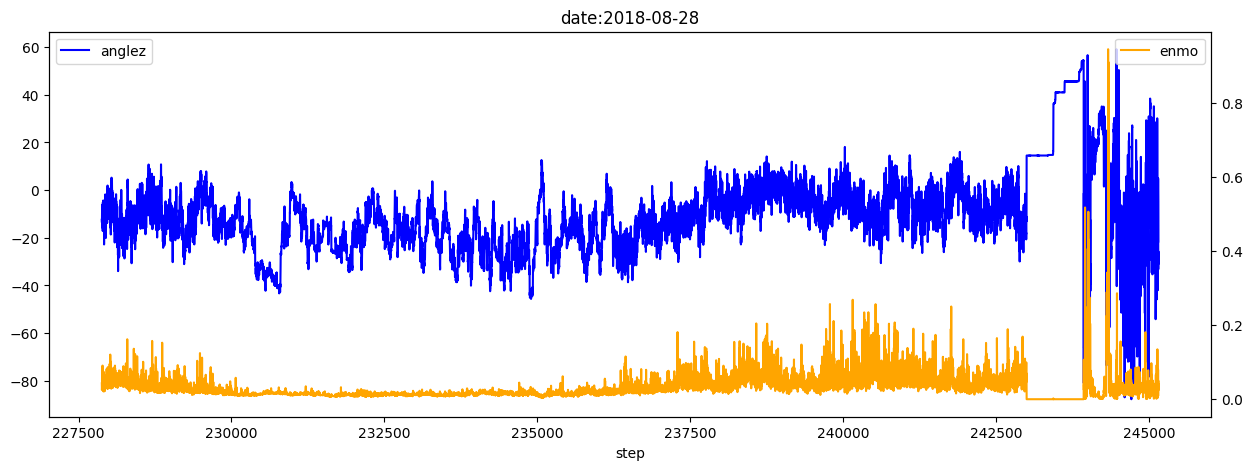

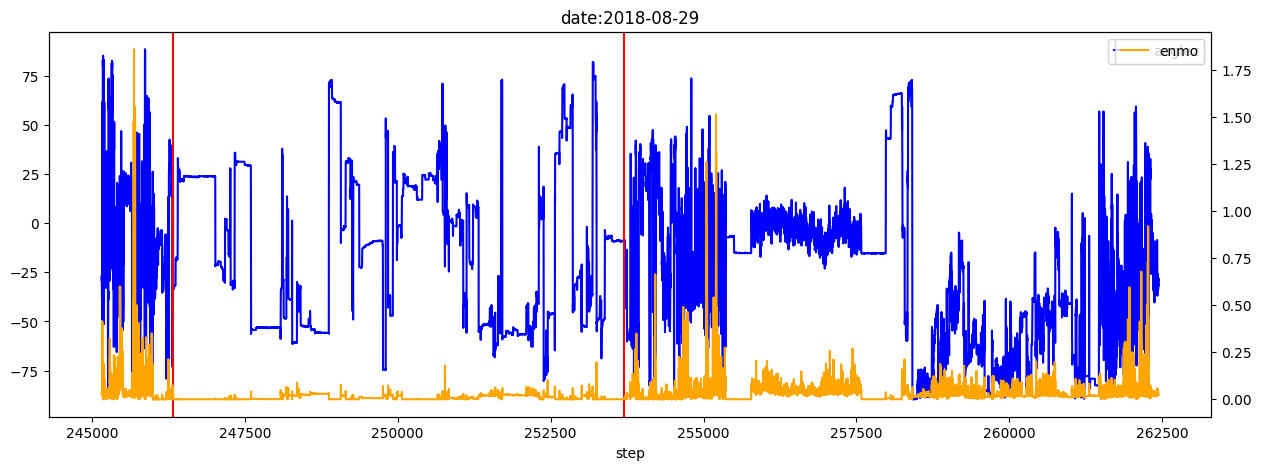

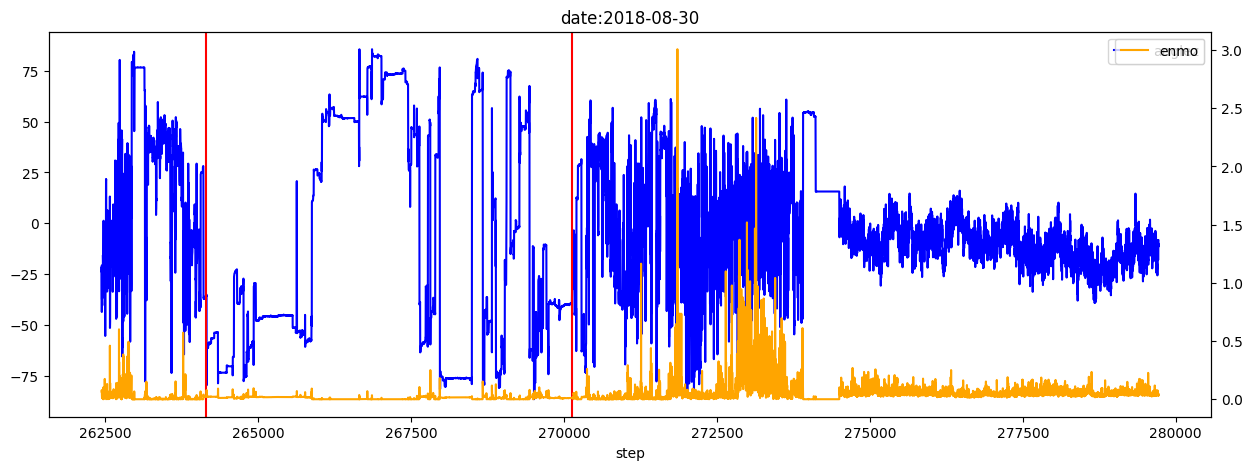

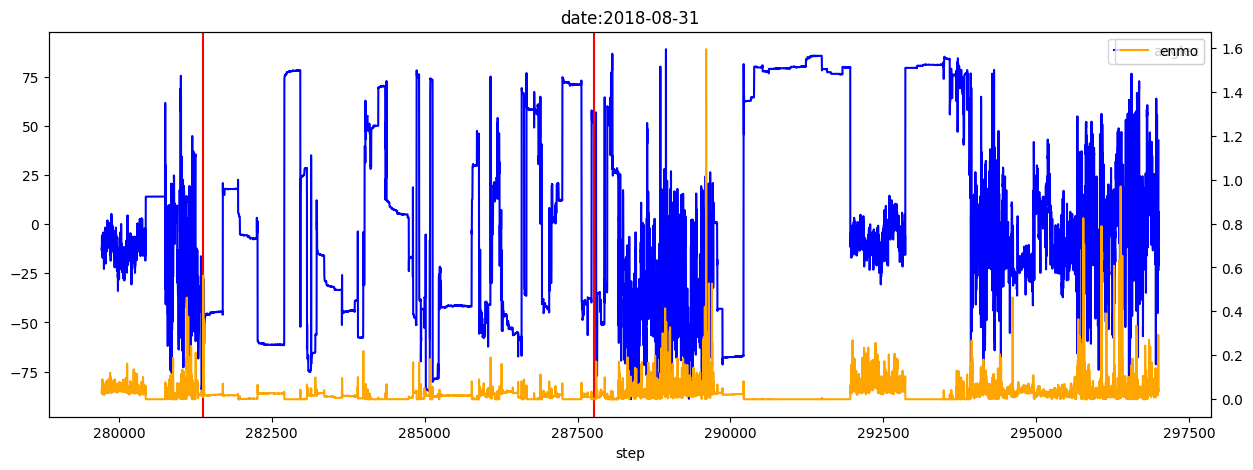

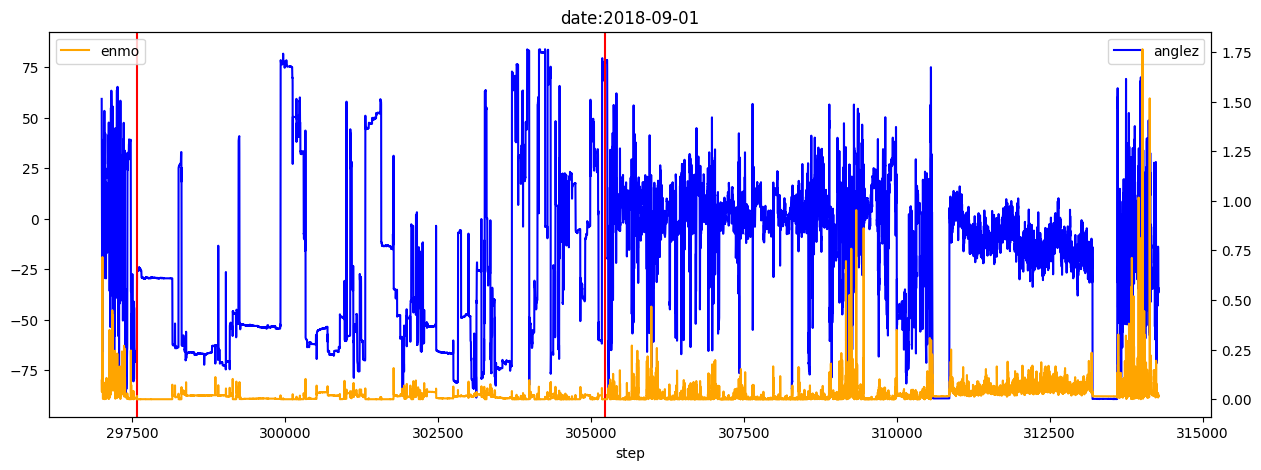

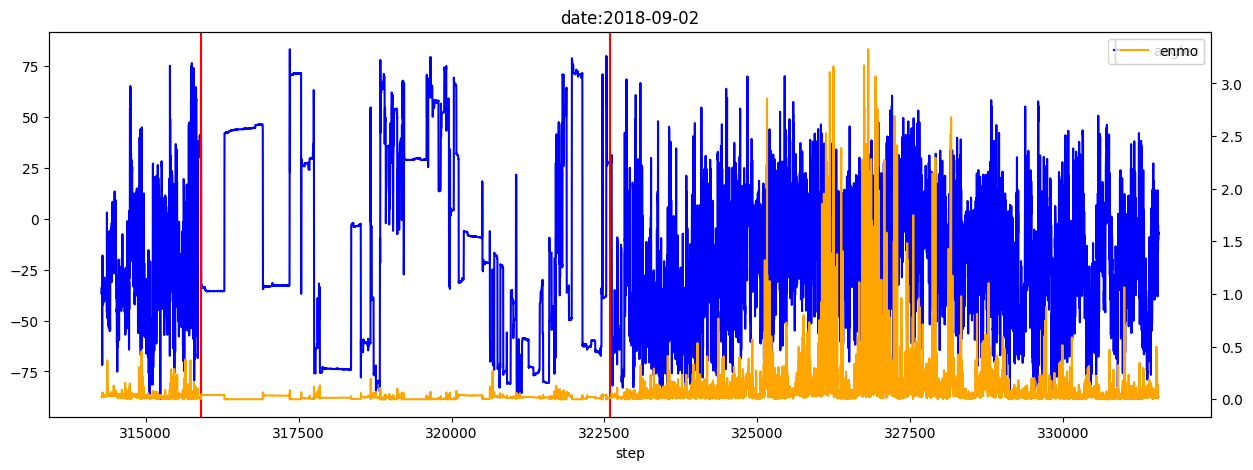

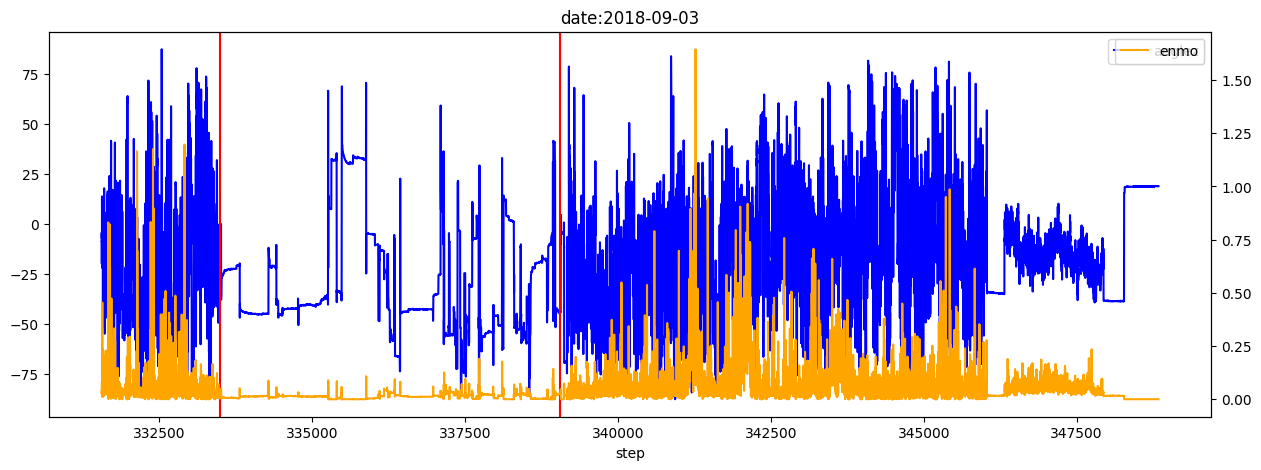

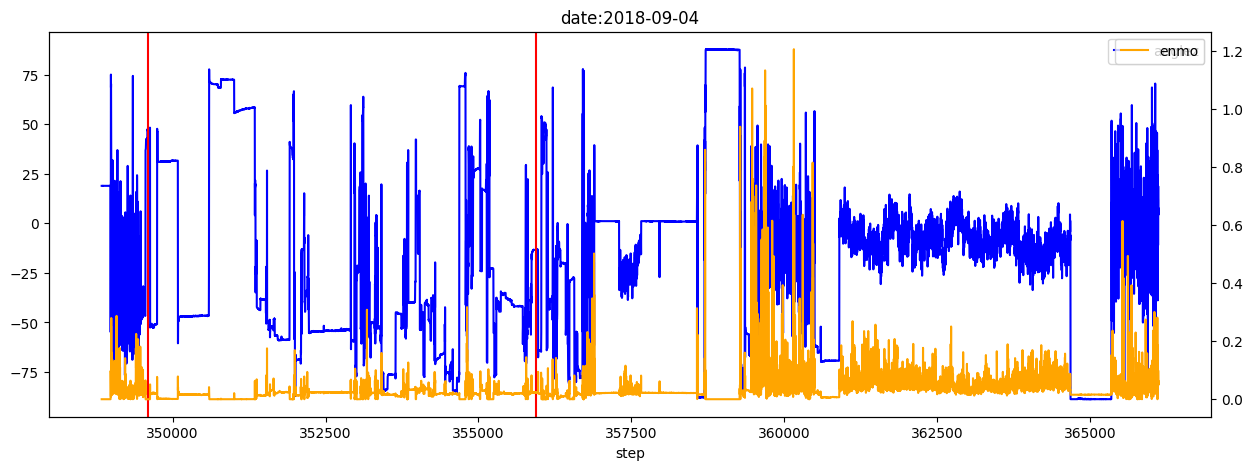

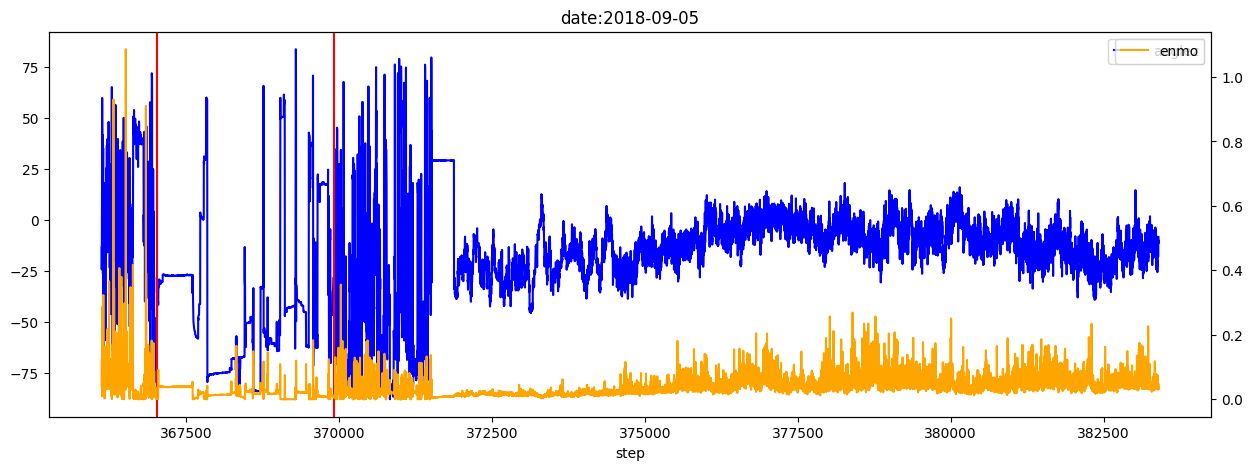

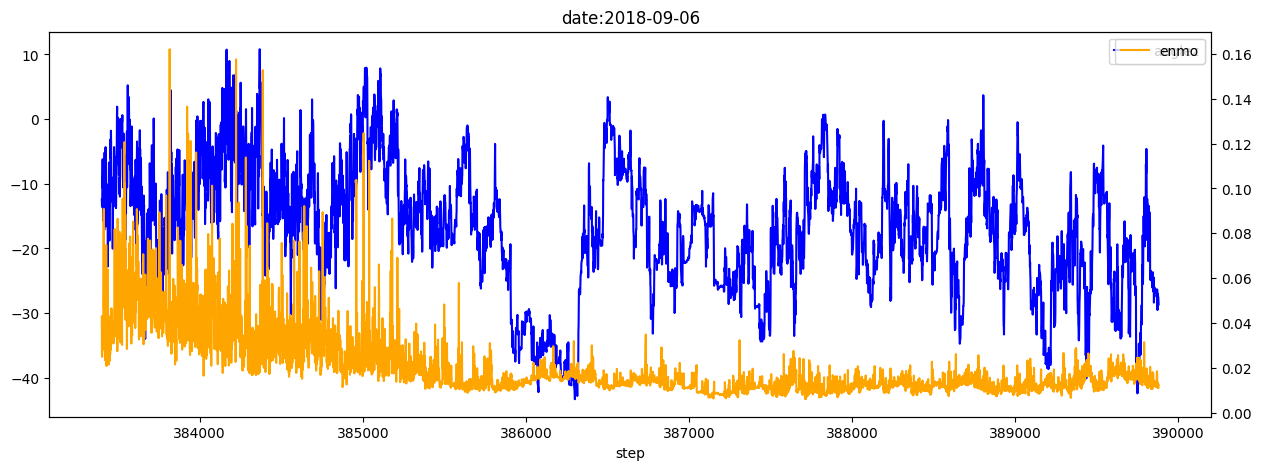

In [32]:
plot_example("038441c925bb")